In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.read_csv('action2.csv').tail()

lh   rh     ls     rs  w   ll  rl        0x       0y       1x  ...  \
2742  610  952  14835  10320  0  318   0  1001.080  224.146  998.267  ...   
2743  467  783  16996  11728  0  318   0   998.267  224.091  998.128  ...   
2744  379  760  16617  13096  0  319   0  1001.080  224.156  998.239  ...   
2745  341  773      0      0  0    0   0   998.403  224.142  998.280  ...   
2746    0    0      0      0  0    0   0   998.403  224.142  998.280  ...   

          20x      20y      21x      21y      22x       22y      23x      23y  \
2742  1115.94  1015.89  1060.06  980.585  836.316   998.339  827.553  983.515   
2743  1115.92  1015.86  1057.12  980.551  833.537  1001.160  827.516  986.498   
2744  1115.94  1015.87  1060.07  980.585  836.354   998.340  827.578  983.524   
2745  1115.93  1015.92  1060.07  980.566  836.371  1001.090  830.405  983.572   
2746  1115.93  1015.92  1060.07  980.566  836.371  1001.090  830.405  983.572   

          24x      24y  
2742  883.591  960.051  
2743  883.555  960.010  
2744  883.553  960.073  
2745  883.621  960.030  
2746  883.621  960.030  

[5 rows x 57 columns]

In [3]:
train_x = []

# Store csv file in a Pandas DataFrame
df = pd.read_csv('action2.csv')

# Scaling the input data
sc = MinMaxScaler()
label_sc = MinMaxScaler()
data = sc.fit_transform(df.values)

# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
label_sc.fit(df.iloc[:,7:57].values)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [4]:
# Define lookback period and split inputs/labels
lookback = 10
inputs = np.zeros((len(data)-lookback,lookback,df.shape[1]))
labels = np.zeros((len(data)-lookback, 50))
print(inputs.shape)
print(labels.shape)
for i in range(lookback, len(data)):
    inputs[i-lookback] = data[i-lookback:i]
    labels[i-lookback] = data[i][7:57]
inputs = inputs.reshape(-1,lookback,df.shape[1])
labels = labels.reshape(-1, 50)
print(inputs.shape)
print(labels.shape)

(2737, 10, 57)
(2737, 50)
(2737, 10, 57)
(2737, 50)


In [5]:
# Split data into train/test portions and combining all data from different files into a single array
test_portion = int(0.1*len(inputs))
train_x = inputs[:-test_portion]
train_y = labels[:-test_portion]
test_x = inputs[-test_portion:]
test_y = labels[-test_portion:]
print(test_y)
labs = torch.from_numpy(np.array(test_y))
label_sc.inverse_transform(labs)

[[0.09849157 0.69086822 0.67445039 ... 0.007707   0.05803422 0.49412166]
 [0.09794553 0.69089436 0.67445039 ... 0.0058655  0.98490439 0.49718862]
 [0.19834824 0.22957504 0.68117098 ... 0.2034511  0.0318685  0.49250298]
 ...
 [0.29561122 0.15171711 0.67638683 ... 0.19976811 0.03690037 0.25166127]
 [0.20425227 0.15135121 0.68105707 ... 0.20304188 0.05971151 0.24799796]
 [0.20425227 0.15135121 0.68105707 ... 0.20304188 0.05971151 0.24799796]]


array([[ 995.304,  244.785,  998.222, ...,  980.708,  883.616,  962.919],
       [ 995.288,  244.786,  998.222, ...,  980.681,  886.379,  962.955],
       [ 998.23 ,  227.135,  998.281, ...,  983.578,  883.538,  962.9  ],
       ...,
       [1001.08 ,  224.156,  998.239, ...,  983.524,  883.553,  960.073],
       [ 998.403,  224.142,  998.28 , ...,  983.572,  883.621,  960.03 ],
       [ 998.403,  224.142,  998.28 , ...,  983.572,  883.621,  960.03 ]])

In [6]:
print(test_y)

[[0.09849157 0.69086822 0.67445039 ... 0.007707   0.05803422 0.49412166]
 [0.09794553 0.69089436 0.67445039 ... 0.0058655  0.98490439 0.49718862]
 [0.19834824 0.22957504 0.68117098 ... 0.2034511  0.0318685  0.49250298]
 ...
 [0.29561122 0.15171711 0.67638683 ... 0.19976811 0.03690037 0.25166127]
 [0.20425227 0.15135121 0.68105707 ... 0.20304188 0.05971151 0.24799796]
 [0.20425227 0.15135121 0.68105707 ... 0.20304188 0.05971151 0.24799796]]


In [7]:
batch_size = 10

train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
input_dim = next(iter(train_loader))[0].shape
print(input_dim)

torch.Size([10, 10, 57])


In [8]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [9]:
print(device)

cpu


In [10]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [11]:
def train(train_loader, learn_rate, hidden_dim=256, EPOCHS=5, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = next(iter(train_loader))[0].shape[2]
    output_dim = 50
    n_layers = 2
    # Instantiating the model
    model = GRUNet(input_dim, hidden_dim, output_dim, n_layers)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.clock()
        h = model.init_hidden(batch_size)
        avg_loss = 0.
        counter = 0
        for x, label in train_loader:
            counter += 1
            h = h.data
            model.zero_grad()
            
            out, h = model(x.to(device).float(), h)
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            #if counter%20 == 0:
            print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), avg_loss/counter))
        current_time = time.clock()
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss/len(train_loader)))
        print("Time Elapsed for Epoch: {} seconds".format(str(current_time-start_time)))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model


In [12]:
def evaluate(model, test_x, test_y, label_sc):
    model.eval()
    outputs = []
    targets = []
    start_time = time.clock()
    
    inp = torch.from_numpy(np.array(test_x))
    labs = torch.from_numpy(np.array(test_y))
    h = model.init_hidden(inp.shape[0])
    out, h = model(inp.to(device).float(), h)
    outputs.append(label_sc.inverse_transform(out.cpu().detach().numpy()).reshape(-1))
    targets.append(label_sc.inverse_transform(labs.numpy()).reshape(-1))
    
    print("Evaluation Time: {}".format(str(time.clock()-start_time)))
    sMAPE = 0
    for i in range(len(outputs)):
        sMAPE += np.mean(abs(outputs[i]-targets[i])/(targets[i]+outputs[i])/2)/len(outputs)
    print("sMAPE: {}%".format(sMAPE*100))
    return outputs, targets, sMAPE

In [13]:
lr = 0.001
gru_model = train(train_loader, lr, model_type="GRU")

Starting Training of GRU model
Epoch 1......Step: 1/246....... Average Loss for Epoch: 0.3408922255039215
Epoch 1......Step: 2/246....... Average Loss for Epoch: 0.3065437227487564
Epoch 1......Step: 3/246....... Average Loss for Epoch: 0.2830442438522975
Epoch 1......Step: 4/246....... Average Loss for Epoch: 0.25378311425447464
Epoch 1......Step: 5/246....... Average Loss for Epoch: 0.2200693428516388
Epoch 1......Step: 6/246....... Average Loss for Epoch: 0.1957800400753816
Epoch 1......Step: 7/246....... Average Loss for Epoch: 0.17680984629052027
Epoch 1......Step: 8/246....... Average Loss for Epoch: 0.1620660489425063
Epoch 1......Step: 9/246....... Average Loss for Epoch: 0.14977013278338644
Epoch 1......Step: 10/246....... Average Loss for Epoch: 0.1390742264688015
Epoch 1......Step: 11/246....... Average Loss for Epoch: 0.12973039157011293
Epoch 1......Step: 12/246....... Average Loss for Epoch: 0.12188984267413616
Epoch 1......Step: 13/246....... Average Loss for Epoch: 0.11

Epoch 1......Step: 113/246....... Average Loss for Epoch: 0.043140978725478715
Epoch 1......Step: 114/246....... Average Loss for Epoch: 0.043041092768442216
Epoch 1......Step: 115/246....... Average Loss for Epoch: 0.04299516060754009
Epoch 1......Step: 116/246....... Average Loss for Epoch: 0.04286377331049278
Epoch 1......Step: 117/246....... Average Loss for Epoch: 0.0427320681225795
Epoch 1......Step: 118/246....... Average Loss for Epoch: 0.04259910608120894
Epoch 1......Step: 119/246....... Average Loss for Epoch: 0.04252979888760743
Epoch 1......Step: 120/246....... Average Loss for Epoch: 0.042468770407140255
Epoch 1......Step: 121/246....... Average Loss for Epoch: 0.042425119187221055
Epoch 1......Step: 122/246....... Average Loss for Epoch: 0.04241779061858771
Epoch 1......Step: 123/246....... Average Loss for Epoch: 0.042335121157934995
Epoch 1......Step: 124/246....... Average Loss for Epoch: 0.04219515964148506
Epoch 1......Step: 125/246....... Average Loss for Epoch: 0.

Epoch 1......Step: 219/246....... Average Loss for Epoch: 0.036191151736805975
Epoch 1......Step: 220/246....... Average Loss for Epoch: 0.03614491811022162
Epoch 1......Step: 221/246....... Average Loss for Epoch: 0.03607680864328713
Epoch 1......Step: 222/246....... Average Loss for Epoch: 0.03602449073212909
Epoch 1......Step: 223/246....... Average Loss for Epoch: 0.035970917823536515
Epoch 1......Step: 224/246....... Average Loss for Epoch: 0.035954539206743776
Epoch 1......Step: 225/246....... Average Loss for Epoch: 0.03589612007968956
Epoch 1......Step: 226/246....... Average Loss for Epoch: 0.035826133341586165
Epoch 1......Step: 227/246....... Average Loss for Epoch: 0.035785986660335556
Epoch 1......Step: 228/246....... Average Loss for Epoch: 0.03572111925633069
Epoch 1......Step: 229/246....... Average Loss for Epoch: 0.03565853519373325
Epoch 1......Step: 230/246....... Average Loss for Epoch: 0.03561181330486484
Epoch 1......Step: 231/246....... Average Loss for Epoch: 0

Epoch 2......Step: 77/246....... Average Loss for Epoch: 0.025559340591554517
Epoch 2......Step: 78/246....... Average Loss for Epoch: 0.025561228060187437
Epoch 2......Step: 79/246....... Average Loss for Epoch: 0.025568898201366014
Epoch 2......Step: 80/246....... Average Loss for Epoch: 0.02562585815321654
Epoch 2......Step: 81/246....... Average Loss for Epoch: 0.0255844053570871
Epoch 2......Step: 82/246....... Average Loss for Epoch: 0.025556256903744325
Epoch 2......Step: 83/246....... Average Loss for Epoch: 0.025598108544048058
Epoch 2......Step: 84/246....... Average Loss for Epoch: 0.025630834157622996
Epoch 2......Step: 85/246....... Average Loss for Epoch: 0.025633819050648633
Epoch 2......Step: 86/246....... Average Loss for Epoch: 0.025607730391933474
Epoch 2......Step: 87/246....... Average Loss for Epoch: 0.025626326450842552
Epoch 2......Step: 88/246....... Average Loss for Epoch: 0.025577089939774436
Epoch 2......Step: 89/246....... Average Loss for Epoch: 0.02554419

Epoch 2......Step: 182/246....... Average Loss for Epoch: 0.024959571178552215
Epoch 2......Step: 183/246....... Average Loss for Epoch: 0.024950611990331953
Epoch 2......Step: 184/246....... Average Loss for Epoch: 0.024923305189156014
Epoch 2......Step: 185/246....... Average Loss for Epoch: 0.02491730287469722
Epoch 2......Step: 186/246....... Average Loss for Epoch: 0.024886383204370418
Epoch 2......Step: 187/246....... Average Loss for Epoch: 0.024830883752335522
Epoch 2......Step: 188/246....... Average Loss for Epoch: 0.024877468059632056
Epoch 2......Step: 189/246....... Average Loss for Epoch: 0.024872846393870614
Epoch 2......Step: 190/246....... Average Loss for Epoch: 0.024895690847188234
Epoch 2......Step: 191/246....... Average Loss for Epoch: 0.024898611013996975
Epoch 2......Step: 192/246....... Average Loss for Epoch: 0.024901645689775858
Epoch 2......Step: 193/246....... Average Loss for Epoch: 0.024866523476886934
Epoch 2......Step: 194/246....... Average Loss for Ep

Epoch 3......Step: 44/246....... Average Loss for Epoch: 0.023785451765764843
Epoch 3......Step: 45/246....... Average Loss for Epoch: 0.02379124876525667
Epoch 3......Step: 46/246....... Average Loss for Epoch: 0.023626676679629345
Epoch 3......Step: 47/246....... Average Loss for Epoch: 0.023519006379424258
Epoch 3......Step: 48/246....... Average Loss for Epoch: 0.023484187084250152
Epoch 3......Step: 49/246....... Average Loss for Epoch: 0.023469451738863577
Epoch 3......Step: 50/246....... Average Loss for Epoch: 0.023578100800514222
Epoch 3......Step: 51/246....... Average Loss for Epoch: 0.02354698146090788
Epoch 3......Step: 52/246....... Average Loss for Epoch: 0.02348507073922799
Epoch 3......Step: 53/246....... Average Loss for Epoch: 0.023482208403776277
Epoch 3......Step: 54/246....... Average Loss for Epoch: 0.023433066835557972
Epoch 3......Step: 55/246....... Average Loss for Epoch: 0.023423060165210202
Epoch 3......Step: 56/246....... Average Loss for Epoch: 0.02348214

Epoch 3......Step: 154/246....... Average Loss for Epoch: 0.023415412330491978
Epoch 3......Step: 155/246....... Average Loss for Epoch: 0.023488713091900273
Epoch 3......Step: 156/246....... Average Loss for Epoch: 0.023481919657056913
Epoch 3......Step: 157/246....... Average Loss for Epoch: 0.023464656440885204
Epoch 3......Step: 158/246....... Average Loss for Epoch: 0.02341362150810376
Epoch 3......Step: 159/246....... Average Loss for Epoch: 0.0233908405457184
Epoch 3......Step: 160/246....... Average Loss for Epoch: 0.023354674788424745
Epoch 3......Step: 161/246....... Average Loss for Epoch: 0.02334068376015617
Epoch 3......Step: 162/246....... Average Loss for Epoch: 0.023328833931620108
Epoch 3......Step: 163/246....... Average Loss for Epoch: 0.0233127776521938
Epoch 3......Step: 164/246....... Average Loss for Epoch: 0.023299516434213373
Epoch 3......Step: 165/246....... Average Loss for Epoch: 0.023270857249471276
Epoch 3......Step: 166/246....... Average Loss for Epoch: 

Epoch 4......Step: 16/246....... Average Loss for Epoch: 0.023838038672693074
Epoch 4......Step: 17/246....... Average Loss for Epoch: 0.024331762838889572
Epoch 4......Step: 18/246....... Average Loss for Epoch: 0.02409441727730963
Epoch 4......Step: 19/246....... Average Loss for Epoch: 0.023963650296393194
Epoch 4......Step: 20/246....... Average Loss for Epoch: 0.02365422509610653
Epoch 4......Step: 21/246....... Average Loss for Epoch: 0.023643311024421736
Epoch 4......Step: 22/246....... Average Loss for Epoch: 0.02370635826479305
Epoch 4......Step: 23/246....... Average Loss for Epoch: 0.02369181585052739
Epoch 4......Step: 24/246....... Average Loss for Epoch: 0.023619202043240268
Epoch 4......Step: 25/246....... Average Loss for Epoch: 0.023415765911340713
Epoch 4......Step: 26/246....... Average Loss for Epoch: 0.023310578643129423
Epoch 4......Step: 27/246....... Average Loss for Epoch: 0.023369605204573384
Epoch 4......Step: 28/246....... Average Loss for Epoch: 0.023448893

Epoch 4......Step: 131/246....... Average Loss for Epoch: 0.022257530066461962
Epoch 4......Step: 132/246....... Average Loss for Epoch: 0.022231460520715424
Epoch 4......Step: 133/246....... Average Loss for Epoch: 0.02228252677933166
Epoch 4......Step: 134/246....... Average Loss for Epoch: 0.022337331450474795
Epoch 4......Step: 135/246....... Average Loss for Epoch: 0.02235803496506479
Epoch 4......Step: 136/246....... Average Loss for Epoch: 0.02237918385414078
Epoch 4......Step: 137/246....... Average Loss for Epoch: 0.02239476908406202
Epoch 4......Step: 138/246....... Average Loss for Epoch: 0.022367758163507435
Epoch 4......Step: 139/246....... Average Loss for Epoch: 0.022317404128450284
Epoch 4......Step: 140/246....... Average Loss for Epoch: 0.022330648052905286
Epoch 4......Step: 141/246....... Average Loss for Epoch: 0.02235577053370628
Epoch 4......Step: 142/246....... Average Loss for Epoch: 0.022423320423654268
Epoch 4......Step: 143/246....... Average Loss for Epoch:

Epoch 4......Step: 244/246....... Average Loss for Epoch: 0.02217716195422118
Epoch 4......Step: 245/246....... Average Loss for Epoch: 0.02215284176018773
Epoch 4......Step: 246/246....... Average Loss for Epoch: 0.02214011955037107
Epoch 4/5 Done, Total Loss: 0.02214011955037107
Time Elapsed for Epoch: 4.547254800000001 seconds
Epoch 5......Step: 1/246....... Average Loss for Epoch: 0.024535970762372017
Epoch 5......Step: 2/246....... Average Loss for Epoch: 0.022871099412441254
Epoch 5......Step: 3/246....... Average Loss for Epoch: 0.021845672900478046
Epoch 5......Step: 4/246....... Average Loss for Epoch: 0.02055328292772174
Epoch 5......Step: 5/246....... Average Loss for Epoch: 0.022207455709576607
Epoch 5......Step: 6/246....... Average Loss for Epoch: 0.021894605519870918
Epoch 5......Step: 7/246....... Average Loss for Epoch: 0.021939428257090703
Epoch 5......Step: 8/246....... Average Loss for Epoch: 0.02211753837764263
Epoch 5......Step: 9/246....... Average Loss for Epoch

Epoch 5......Step: 110/246....... Average Loss for Epoch: 0.022190918587148188
Epoch 5......Step: 111/246....... Average Loss for Epoch: 0.022119219305815997
Epoch 5......Step: 112/246....... Average Loss for Epoch: 0.022084305778012743
Epoch 5......Step: 113/246....... Average Loss for Epoch: 0.022038050407988834
Epoch 5......Step: 114/246....... Average Loss for Epoch: 0.022002656029112506
Epoch 5......Step: 115/246....... Average Loss for Epoch: 0.022003413817804792
Epoch 5......Step: 116/246....... Average Loss for Epoch: 0.021986945339574897
Epoch 5......Step: 117/246....... Average Loss for Epoch: 0.021946545881338608
Epoch 5......Step: 118/246....... Average Loss for Epoch: 0.021971573895317013
Epoch 5......Step: 119/246....... Average Loss for Epoch: 0.021926918372261423
Epoch 5......Step: 120/246....... Average Loss for Epoch: 0.02190660093910992
Epoch 5......Step: 121/246....... Average Loss for Epoch: 0.021903469173376225
Epoch 5......Step: 122/246....... Average Loss for Ep

Epoch 5......Step: 222/246....... Average Loss for Epoch: 0.021514392566976247
Epoch 5......Step: 223/246....... Average Loss for Epoch: 0.021495720354898627
Epoch 5......Step: 224/246....... Average Loss for Epoch: 0.021508403729447827
Epoch 5......Step: 225/246....... Average Loss for Epoch: 0.021486651218599745
Epoch 5......Step: 226/246....... Average Loss for Epoch: 0.02146472585741925
Epoch 5......Step: 227/246....... Average Loss for Epoch: 0.021458241440322955
Epoch 5......Step: 228/246....... Average Loss for Epoch: 0.021440283934536734
Epoch 5......Step: 229/246....... Average Loss for Epoch: 0.02143610389211813
Epoch 5......Step: 230/246....... Average Loss for Epoch: 0.021419417534185494
Epoch 5......Step: 231/246....... Average Loss for Epoch: 0.021419542257016873
Epoch 5......Step: 232/246....... Average Loss for Epoch: 0.021424930350020015
Epoch 5......Step: 233/246....... Average Loss for Epoch: 0.021415324577893823
Epoch 5......Step: 234/246....... Average Loss for Epo

In [14]:
gru_outputs, targets, gru_sMAPE = evaluate(gru_model, test_x, test_y, label_sc)

Evaluation Time: 0.06069659999999999
sMAPE: 0.18042665096476207%


In [15]:
print(gru_outputs[0].reshape(-1, 50))

[[ 997.8634   244.35754  996.8323  ...  981.2728   883.5282   964.0217 ]
 [ 998.1186   244.4374   996.9208  ...  981.2317   883.5292   963.97986]
 [1000.3053   245.91624  996.8253  ...  981.1704   883.52264  964.0861 ]
 ...
 [ 999.9779   225.20232  997.5591  ...  986.2083   883.56586  961.41235]
 [ 999.2478   225.32011  997.4554  ...  986.1617   883.60376  961.12335]
 [ 999.0967   225.31696  997.7584  ...  985.907    883.6045   961.1722 ]]


In [16]:
print(targets[0].reshape(-1, 50))
print(targets[0].reshape(-1, 50)[-1].reshape(-1,2).tolist())

[[ 995.304  244.785  998.222 ...  980.708  883.616  962.919]
 [ 995.288  244.786  998.222 ...  980.681  886.379  962.955]
 [ 998.23   227.135  998.281 ...  983.578  883.538  962.9  ]
 ...
 [1001.08   224.156  998.239 ...  983.524  883.553  960.073]
 [ 998.403  224.142  998.28  ...  983.572  883.621  960.03 ]
 [ 998.403  224.142  998.28  ...  983.572  883.621  960.03 ]]
[[998.4030000000001, 224.14199999999997], [998.28, 347.79900000000004], [912.868, 344.939], [883.4730000000001, 480.226], [880.627, 436.001], [1083.62, 350.79900000000004], [1107.18, 483.102], [1080.65, 436.119], [986.4630000000001, 589.191], [933.543, 586.217], [909.9479999999999, 765.725], [880.431, 951.055], [1042.36, 592.07], [1051.36, 786.2389999999999], [1071.73, 971.7769999999998], [980.6119999999999, 203.63800000000003], [1021.7400000000001, 209.45200000000003], [954.2610000000001, 224.078], [1045.26, 230.02599999999998], [1095.51, 1024.76], [1115.93, 1015.92], [1060.07, 980.566], [836.3710000000001, 1001.0900000

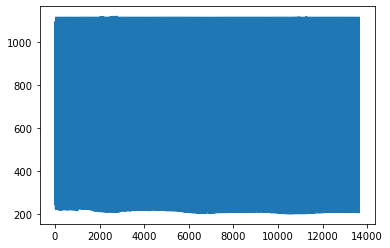

In [17]:
plt.plot(gru_outputs[0])
plt.show()

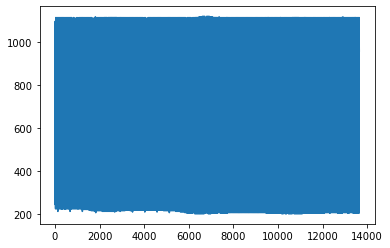

In [18]:
plt.plot(targets[0])
plt.show()

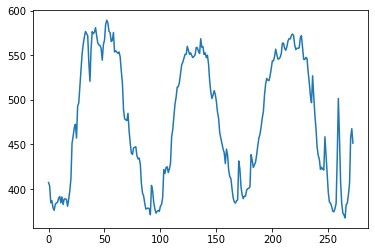

In [19]:
tp = []
for row in gru_outputs[0].reshape(-1, 50):
    tp.append(row[9])
plt.plot(tp)
plt.show()

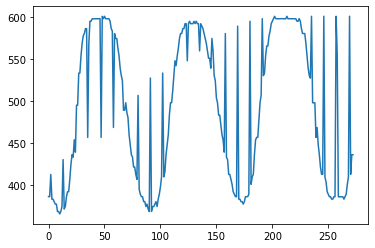

In [20]:
tp = []
for row in targets[0].reshape(-1, 50):
    tp.append(row[9])
plt.plot(tp)
plt.show()

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# h36m骨架连接顺序，每个骨架三个维度，分别为：起始关节，终止关节，左右关节标识(0 left 1 right)
connectivity_dict = [[0, 1, 0], [0, 15, 0], [0, 16, 1], [17, 15, 0], [18, 16, 1], [1, 2, 0], [2, 3, 0],
                              [3, 4, 0], [1, 5, 1], [5, 6, 1],
                              [6, 7, 1], [1, 8, 0], [8, 9, 0], [9, 10, 0], [10, 11, 0], [11, 24, 0],
                              [11, 22, 0], [22, 23, 0], [8, 12, 1], [12, 13, 1], [13, 14, 1], [14, 21, 1],
                              [14, 19, 1], [19, 20, 1]]


def draw2Dpose(pose_2d, ax, lcolor="#3498db", rcolor="#e74c3c", add_labels=False):  # blue, orange
    for i in connectivity_dict:
        x, y = [np.array([pose_2d[i[0], j], pose_2d[i[1], j]]) for j in range(2)]
        ax.plot(x, y, lw=2, c=lcolor if i[2] else rcolor)
        

In [26]:
ps = []
for p in gru_outputs[0].reshape(-1, 50):
    ps.append(np.array(p.reshape(-1,2).tolist()))

print(ps)

[array([[ 997.86340332,  244.35754395],
       [ 996.83227539,  347.89074707],
       [ 912.59863281,  346.63571167],
       [ 885.7442627 ,  476.04663086],
       [ 885.90435791,  407.28857422],
       [1075.8359375 ,  349.53192139],
       [1093.52990723,  482.81195068],
       [1096.11499023,  407.66098022],
       [ 985.21392822,  590.96252441],
       [ 934.1484375 ,  586.19903564],
       [ 908.30413818,  765.40185547],
       [ 880.24395752,  950.81433105],
       [1038.27636719,  590.91955566],
       [1051.62585449,  780.9440918 ],
       [1069.78100586,  969.45501709],
       [ 977.98138428,  224.62994385],
       [1016.51483154,  222.96315002],
       [ 952.76397705,  226.28883362],
       [ 973.20471191,  223.67407227],
       [1095.77758789, 1024.66320801],
       [1115.7088623 , 1014.40966797],
       [1058.16833496,  978.60632324],
       [ 834.66748047,  998.44561768],
       [ 827.58477783,  981.27282715],
       [ 883.52819824,  964.02172852]]), array([[ 998.11859131,

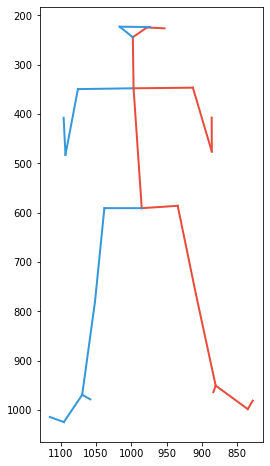

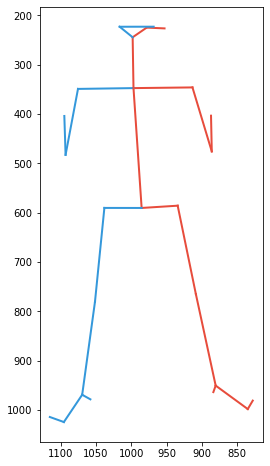

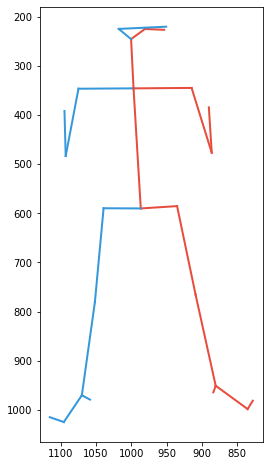

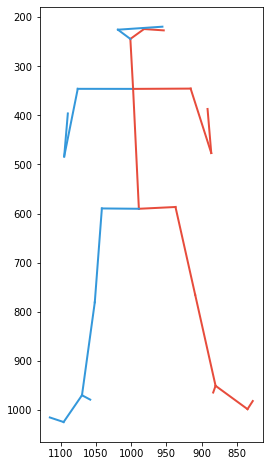

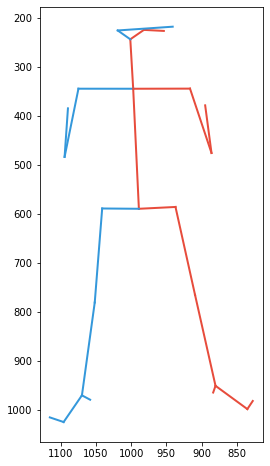

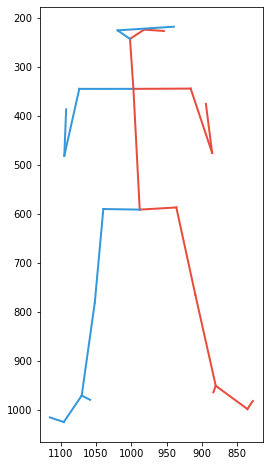

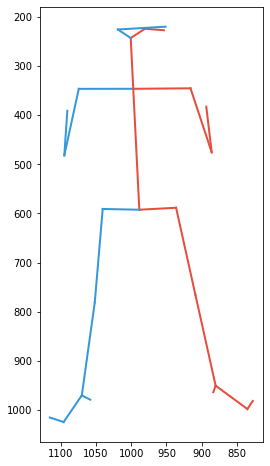

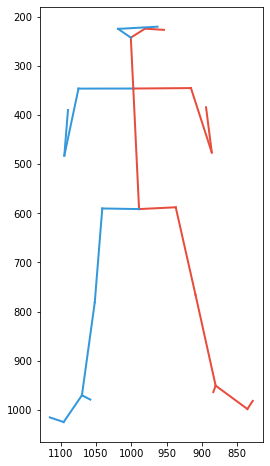

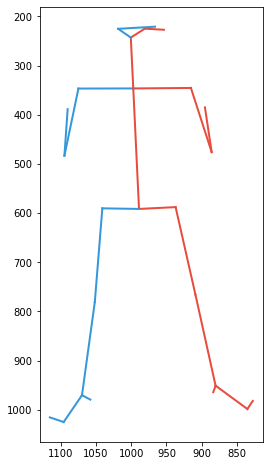

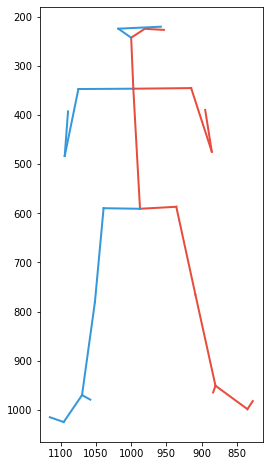

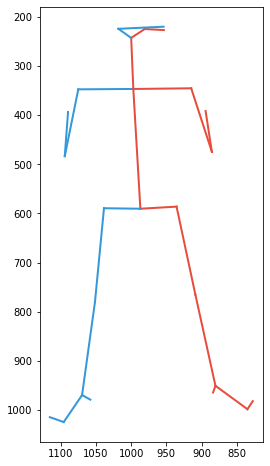

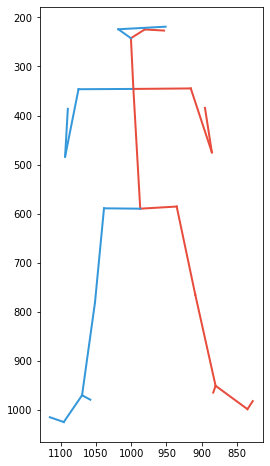

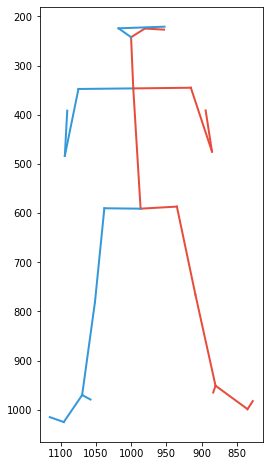

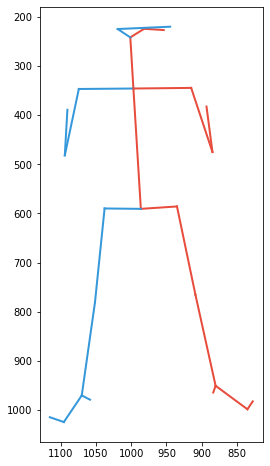

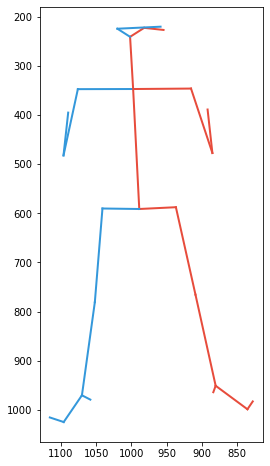

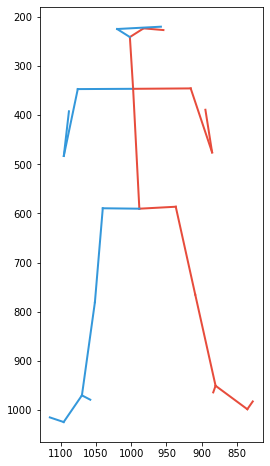

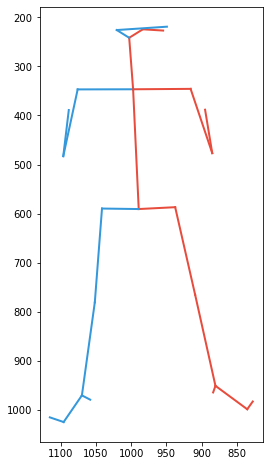

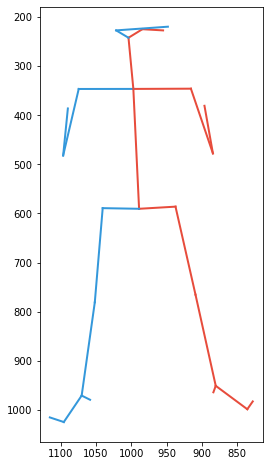

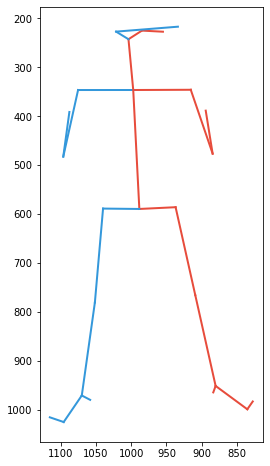

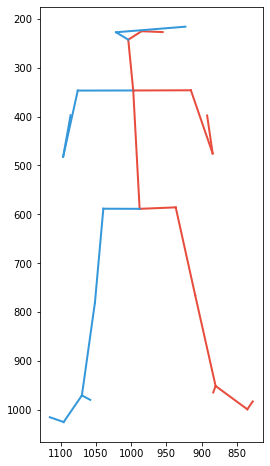

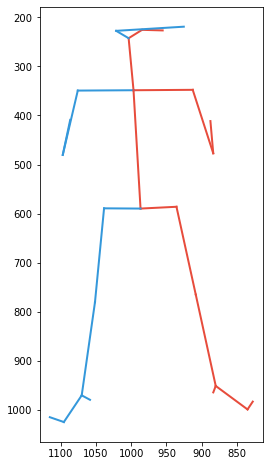

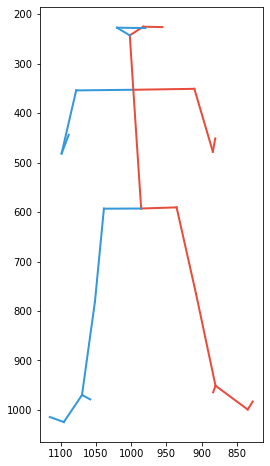

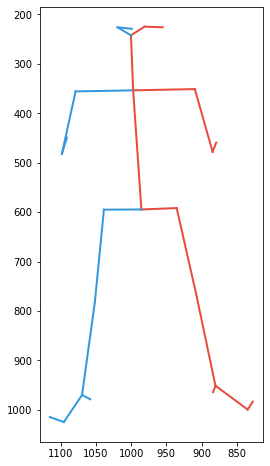

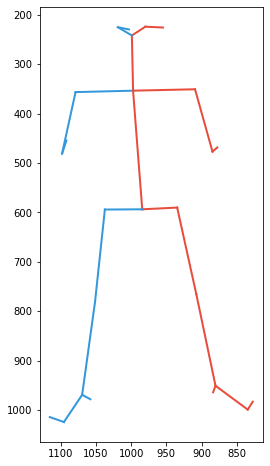

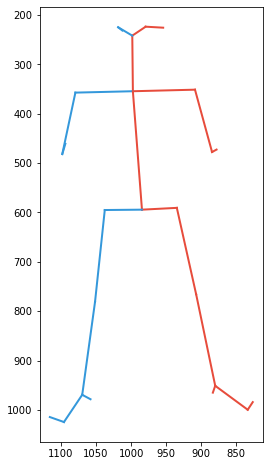

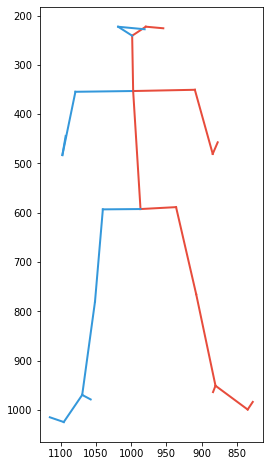

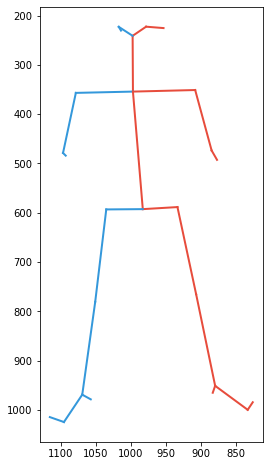

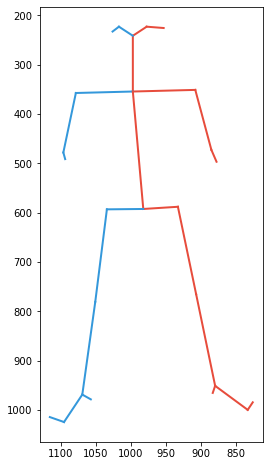

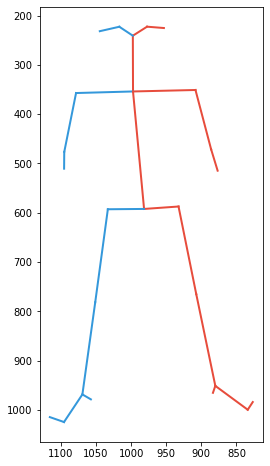

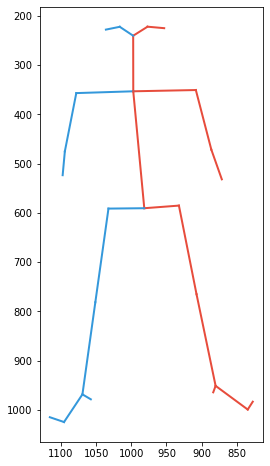

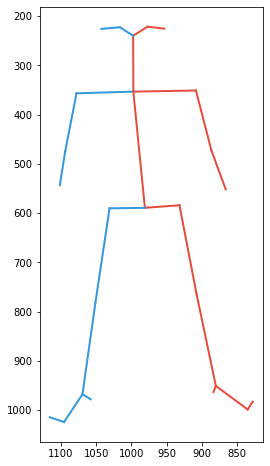

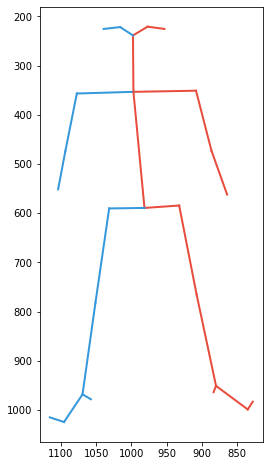

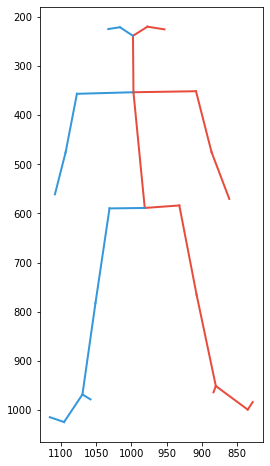

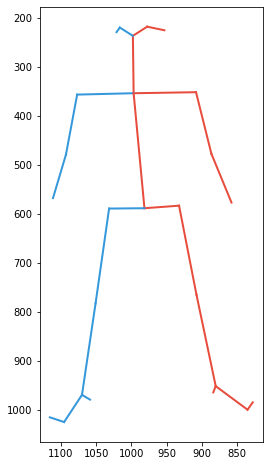

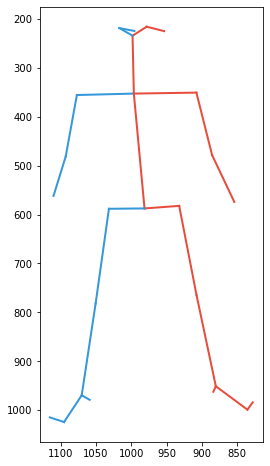

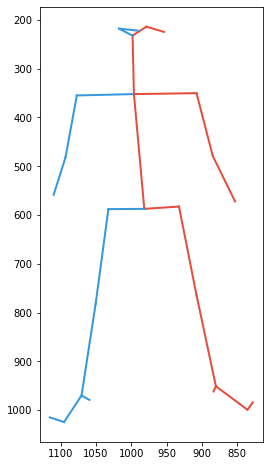

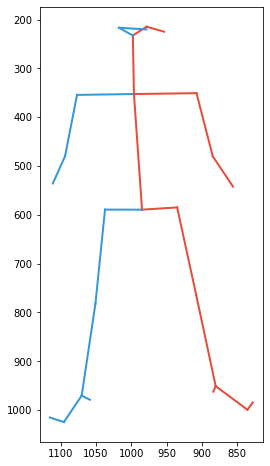

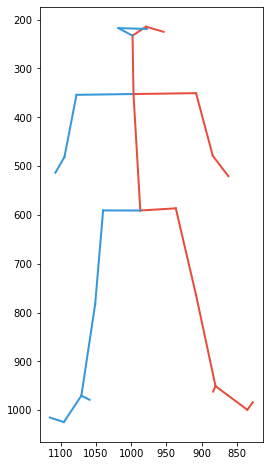

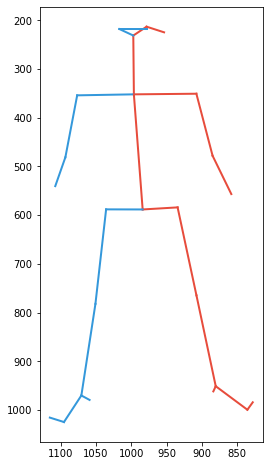

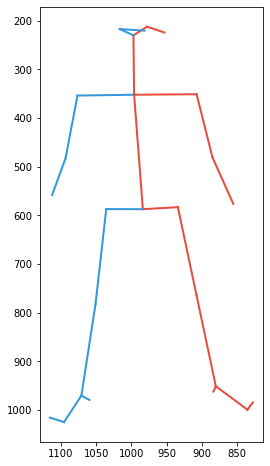

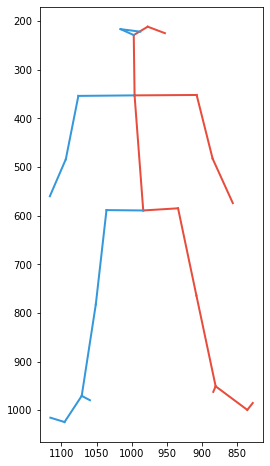

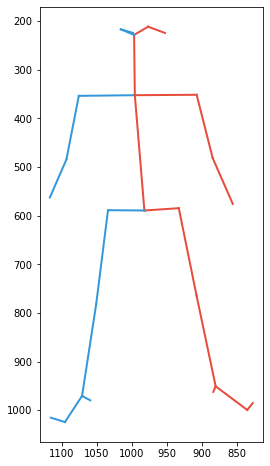

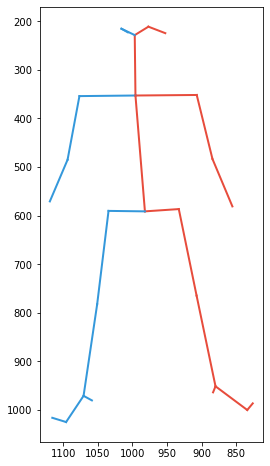

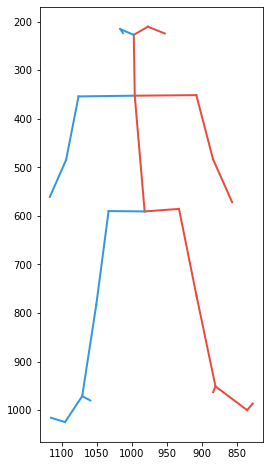

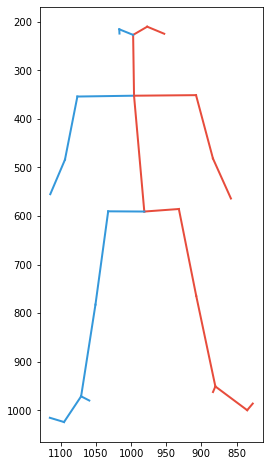

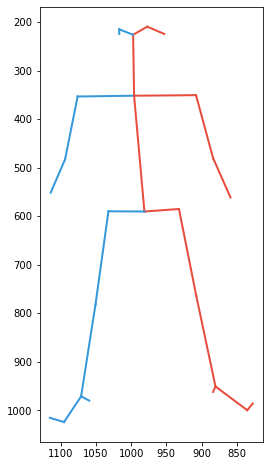

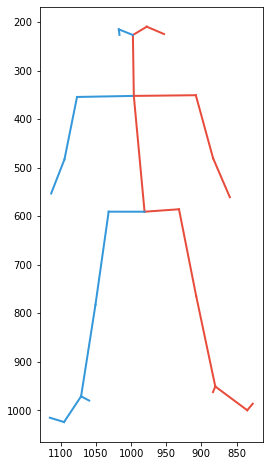

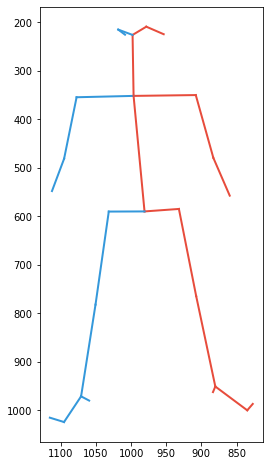

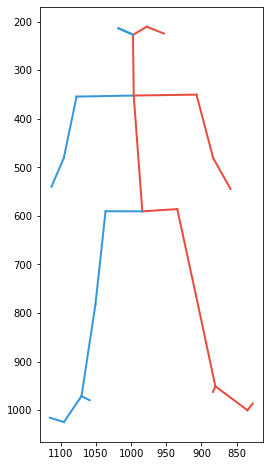

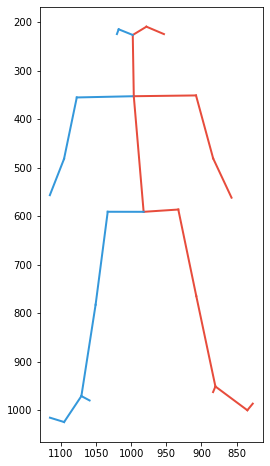

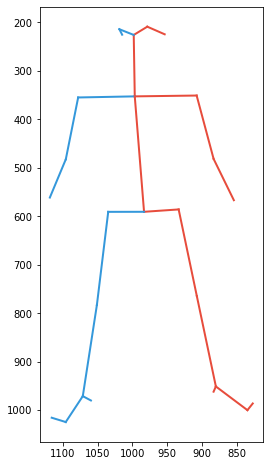

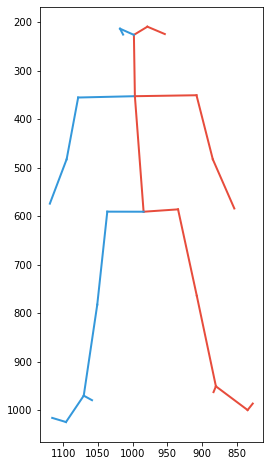

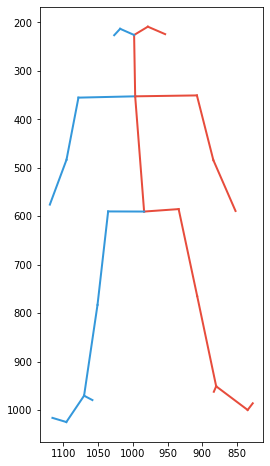

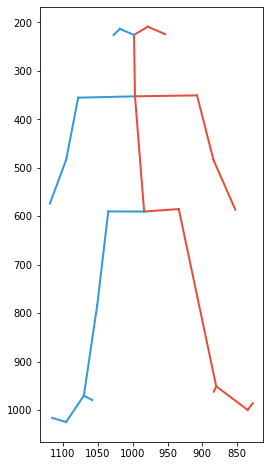

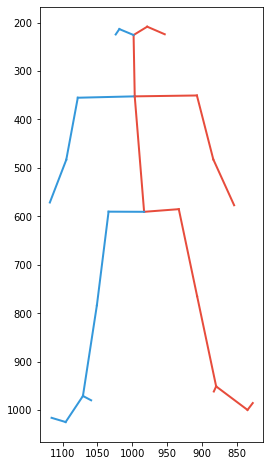

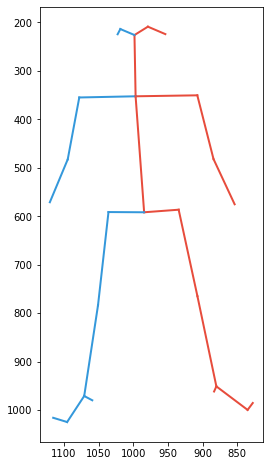

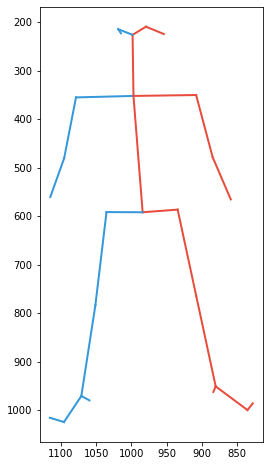

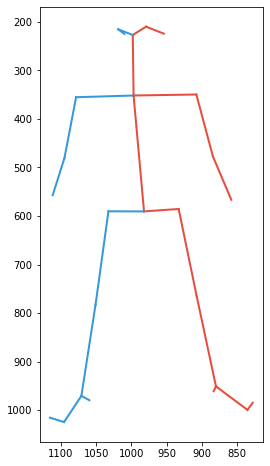

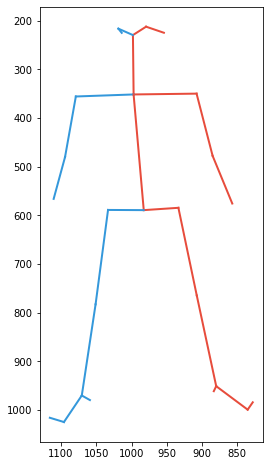

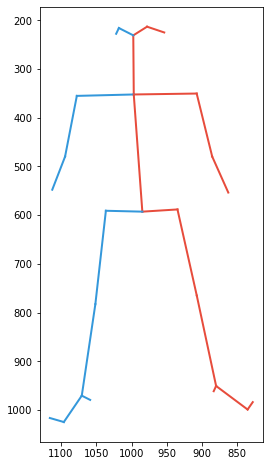

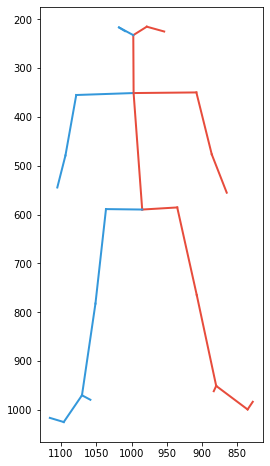

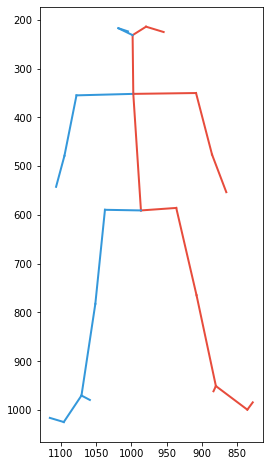

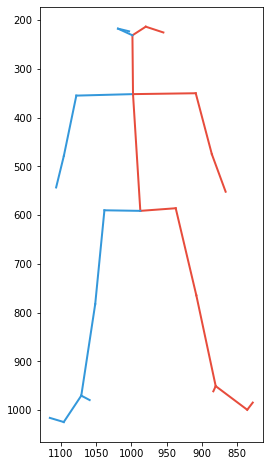

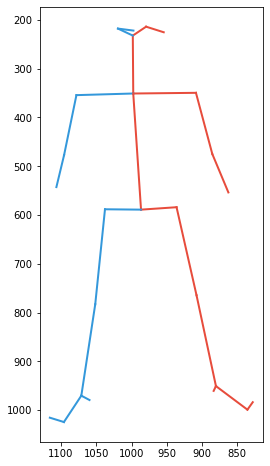

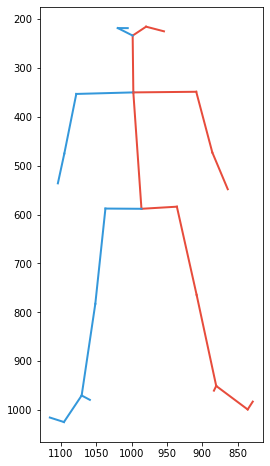

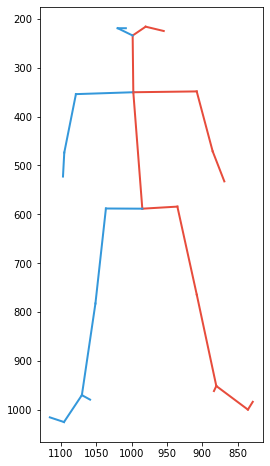

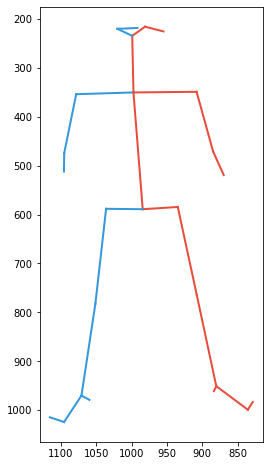

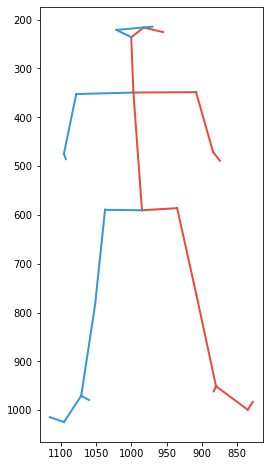

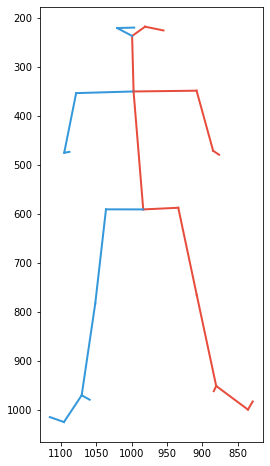

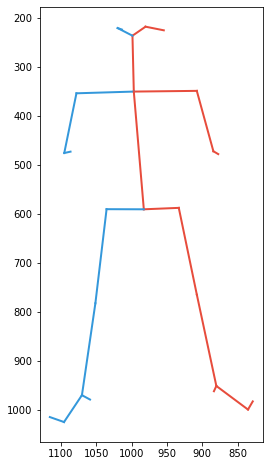

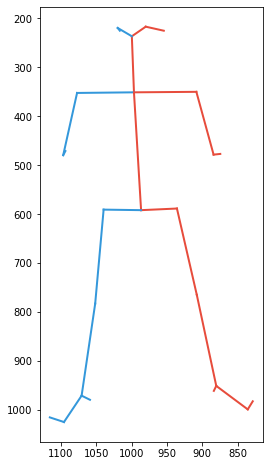

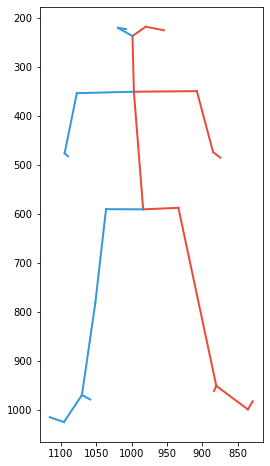

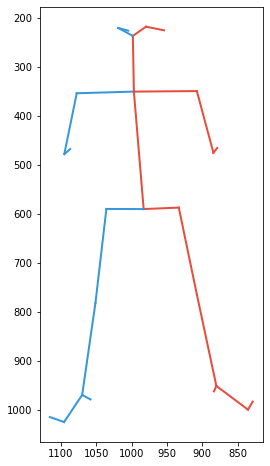

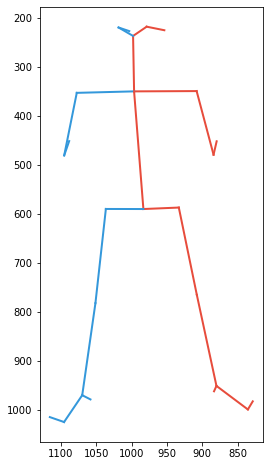

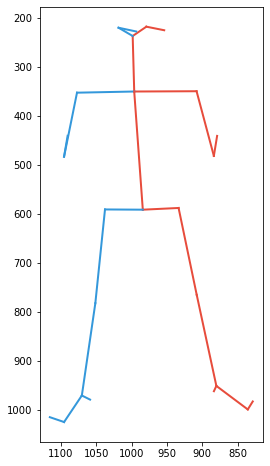

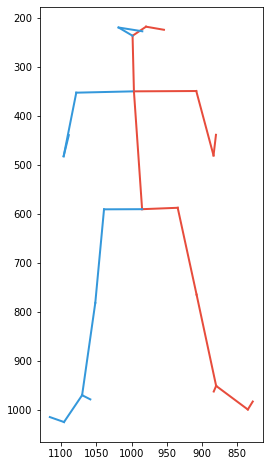

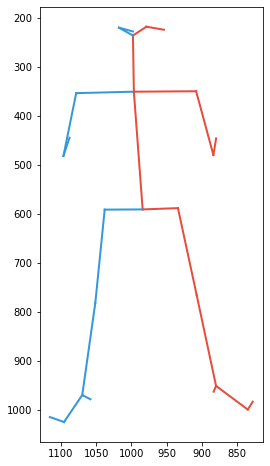

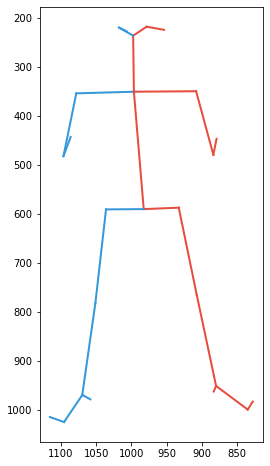

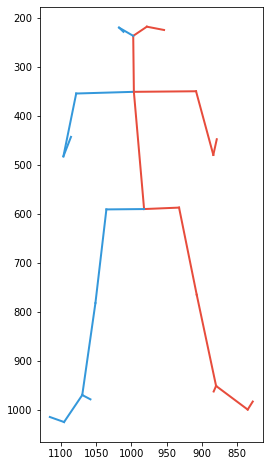

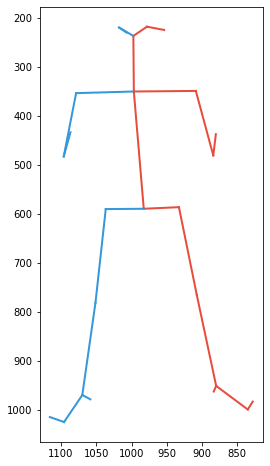

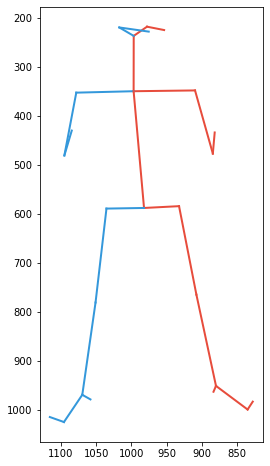

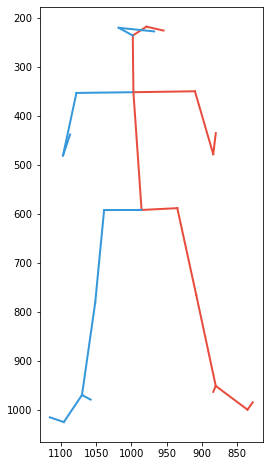

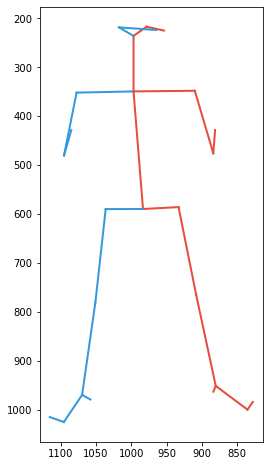

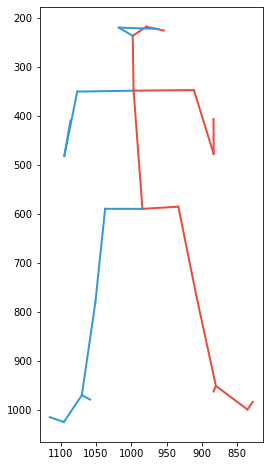

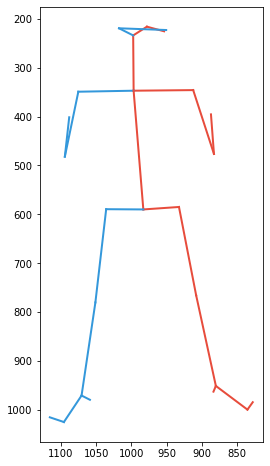

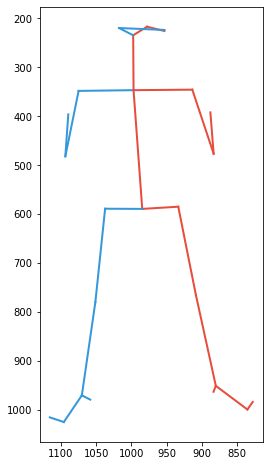

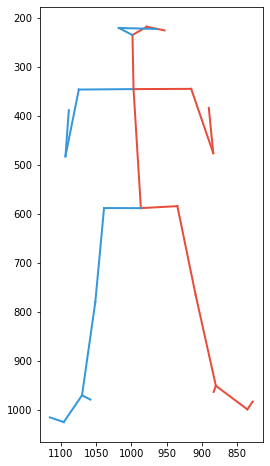

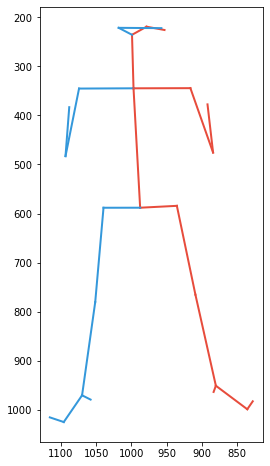

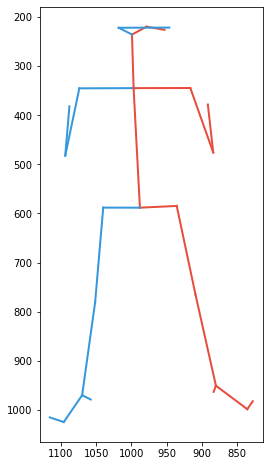

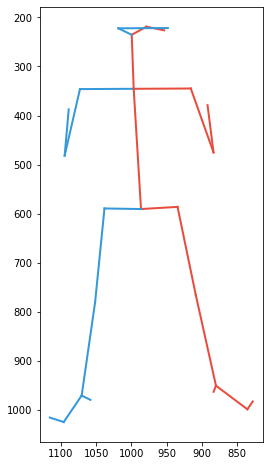

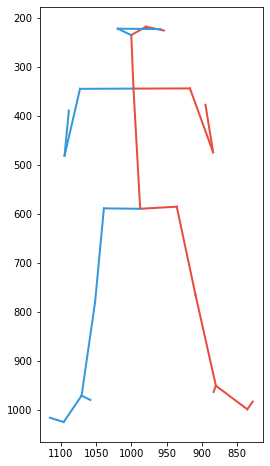

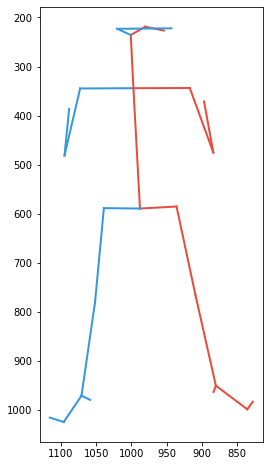

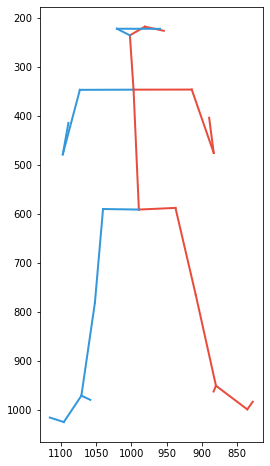

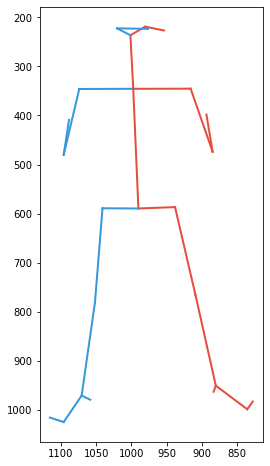

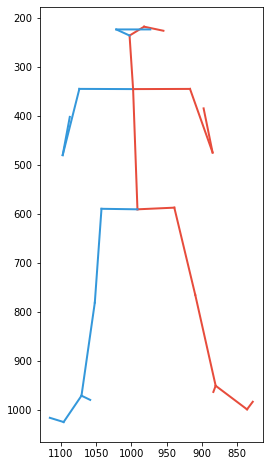

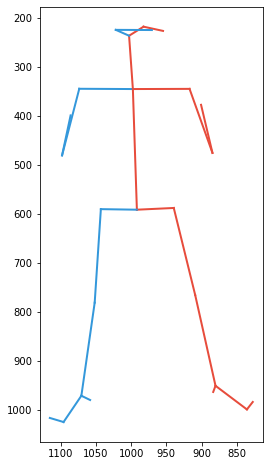

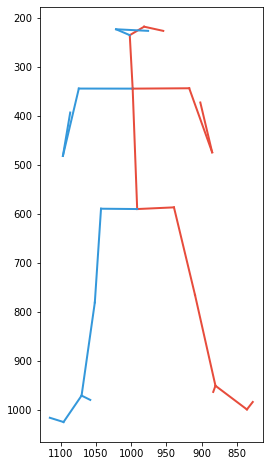

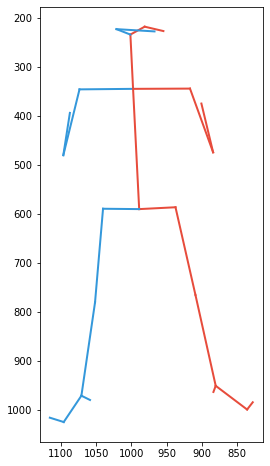

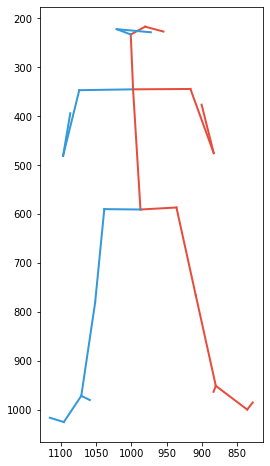

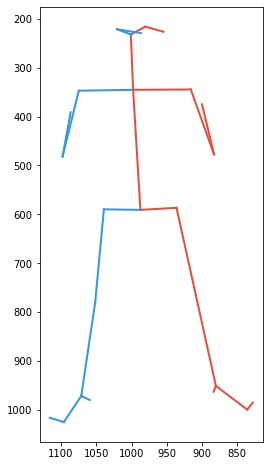

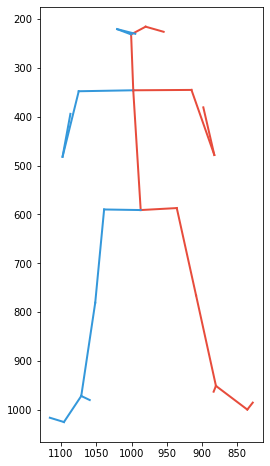

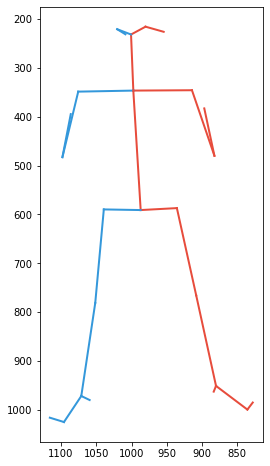

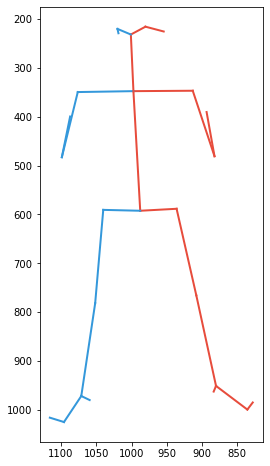

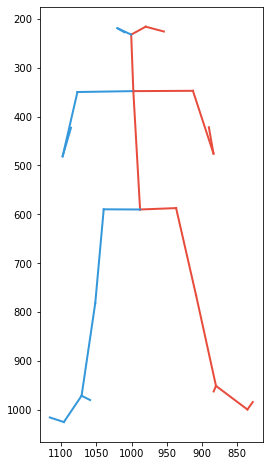

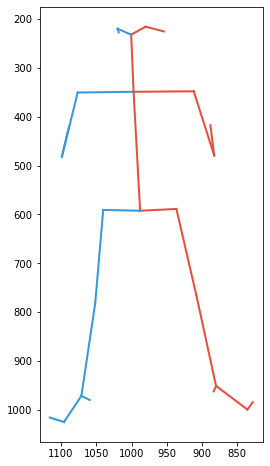

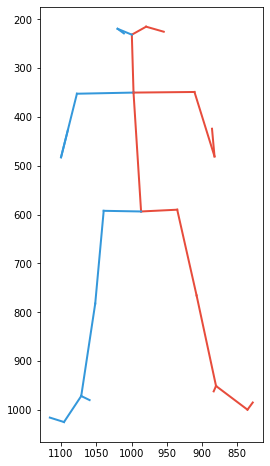

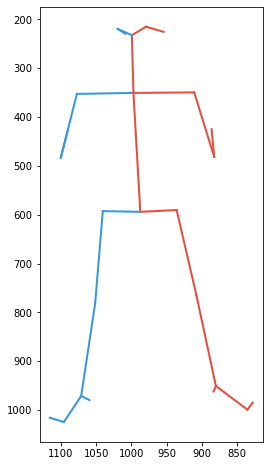

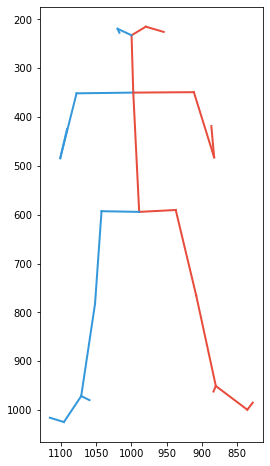

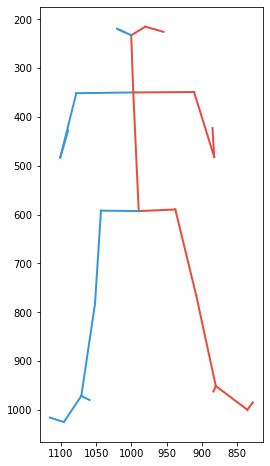

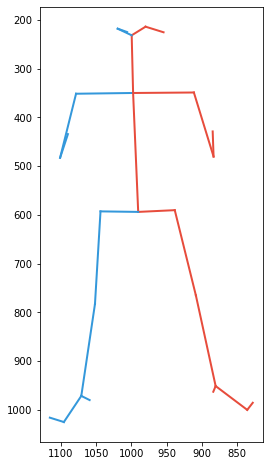

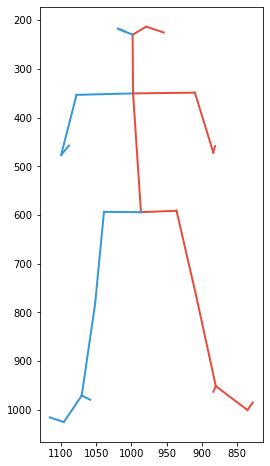

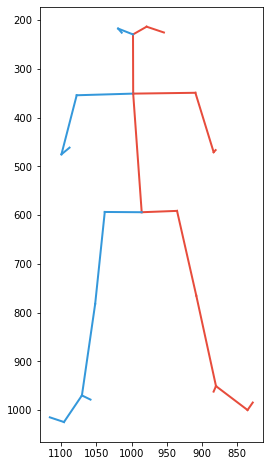

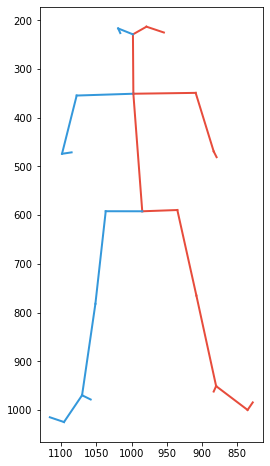

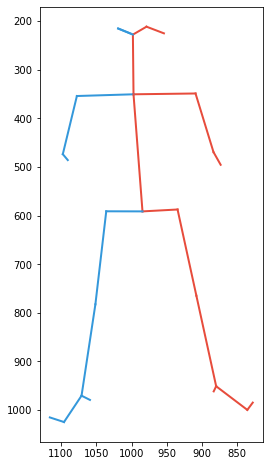

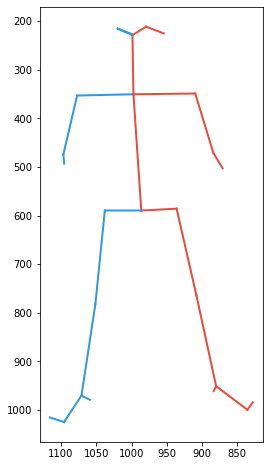

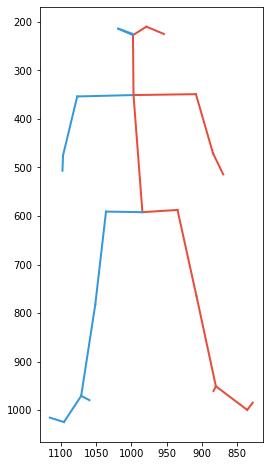

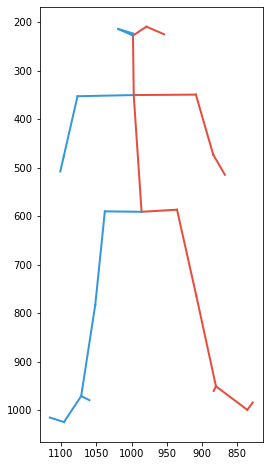

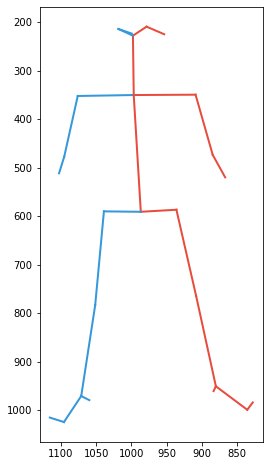

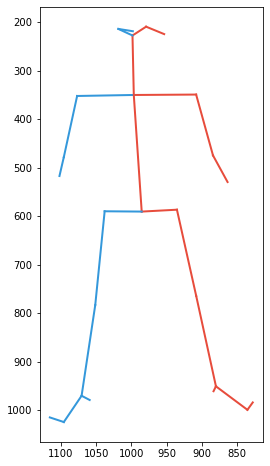

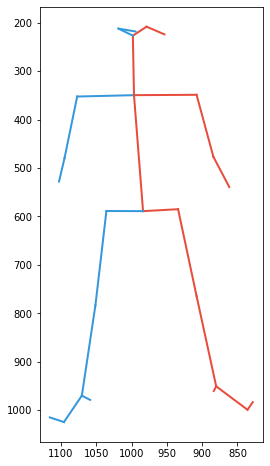

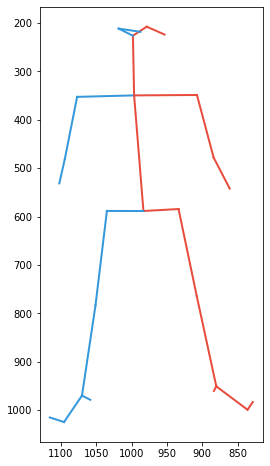

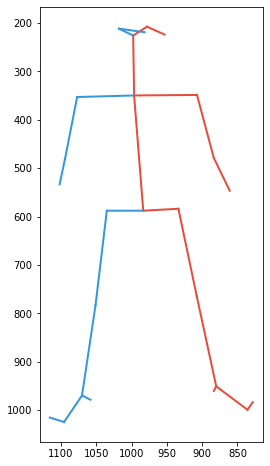

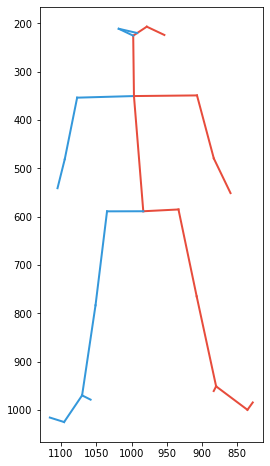

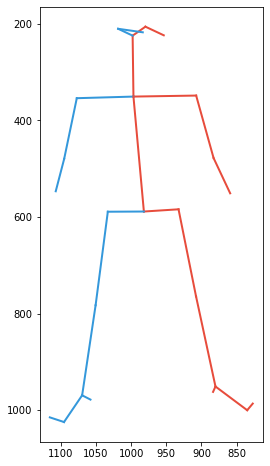

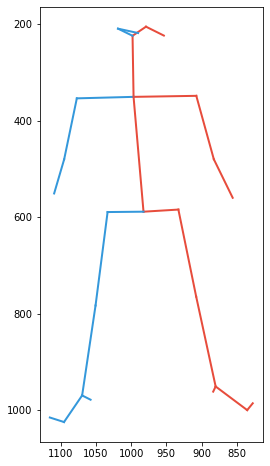

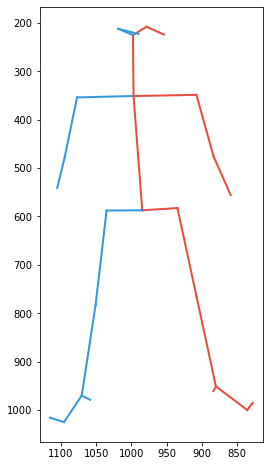

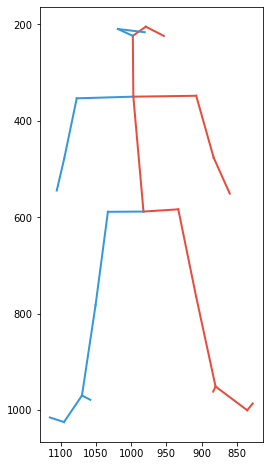

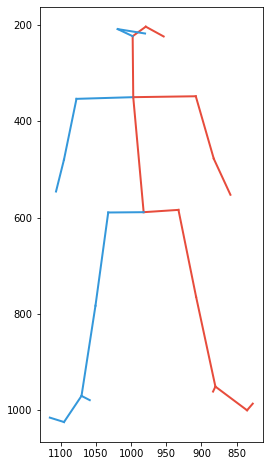

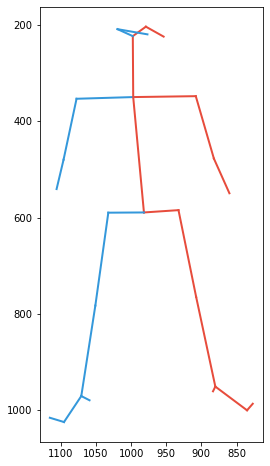

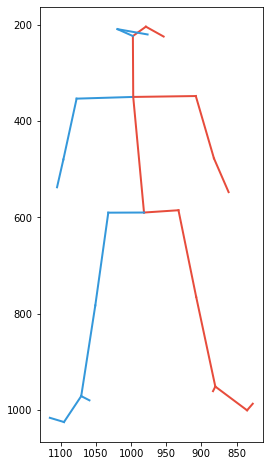

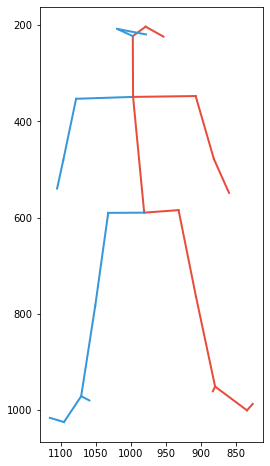

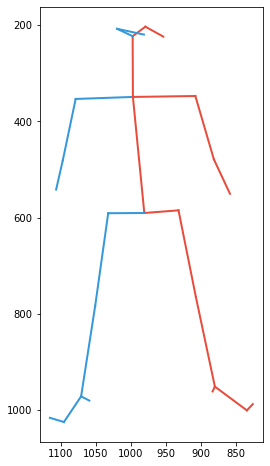

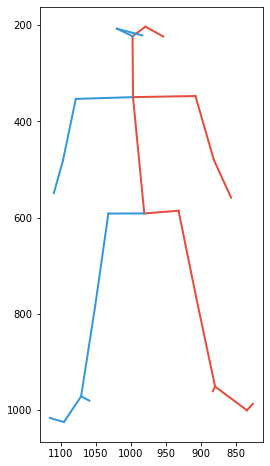

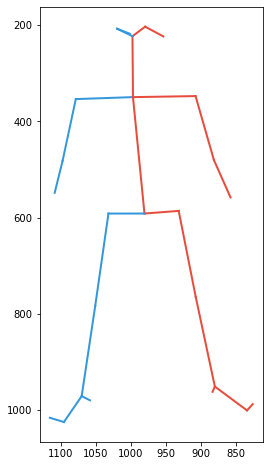

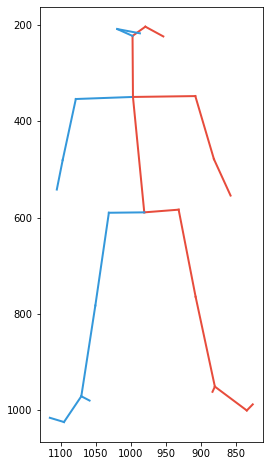

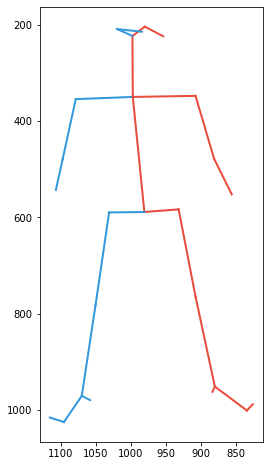

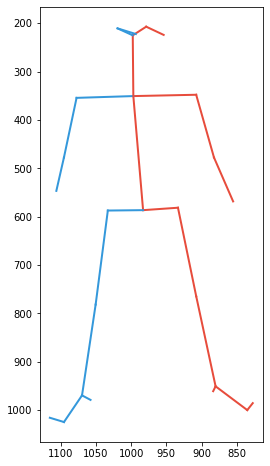

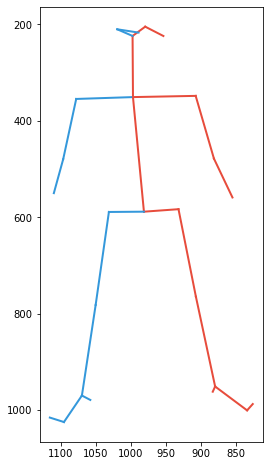

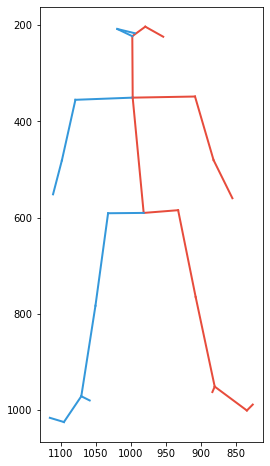

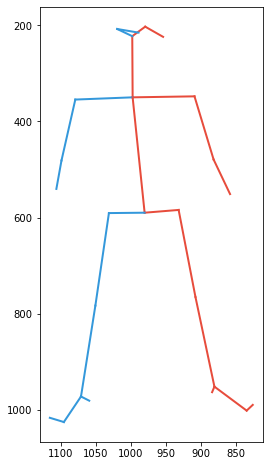

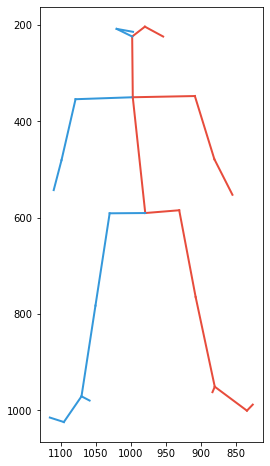

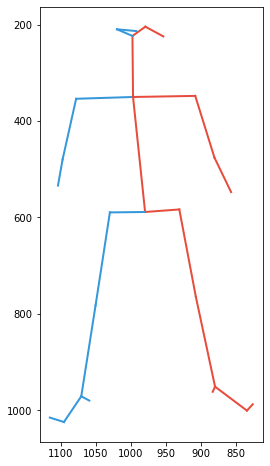

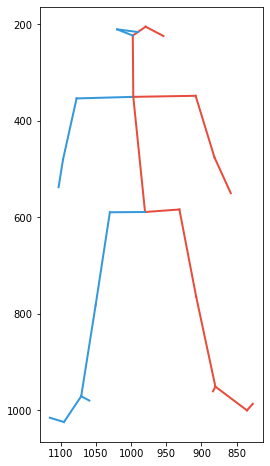

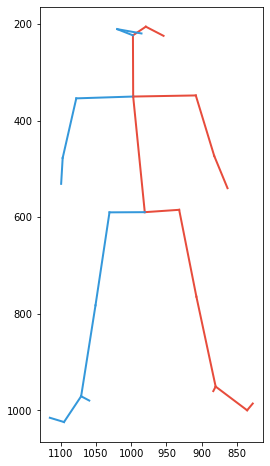

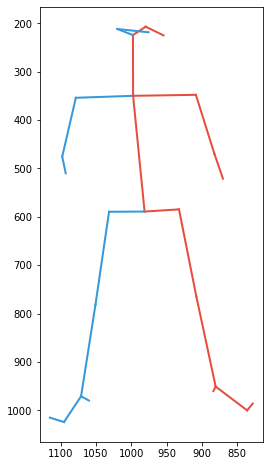

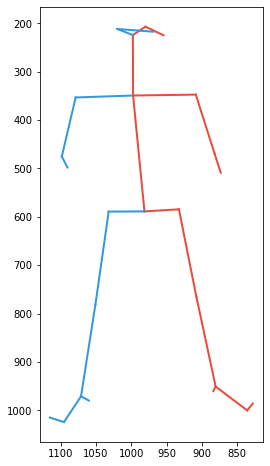

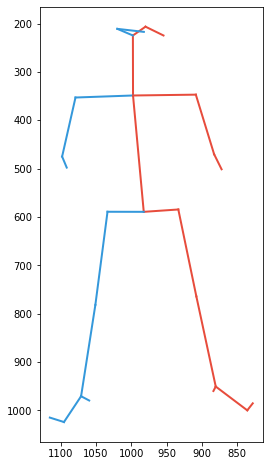

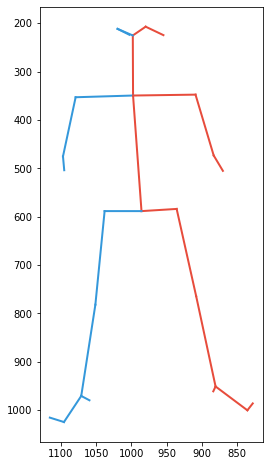

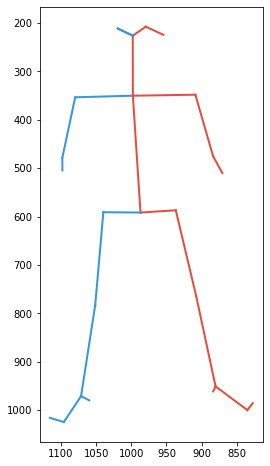

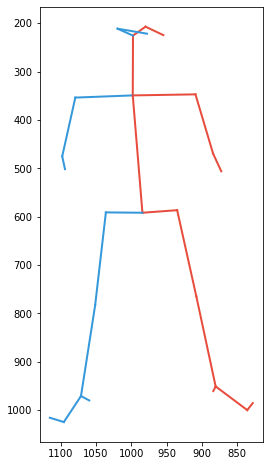

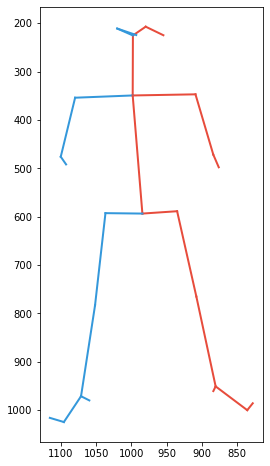

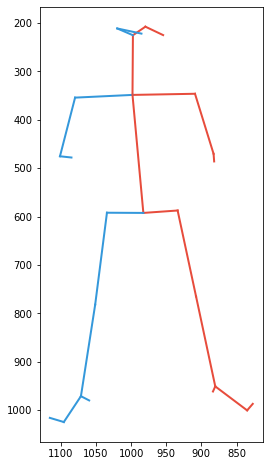

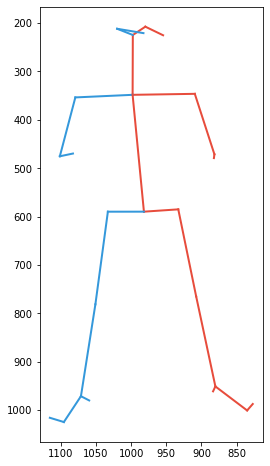

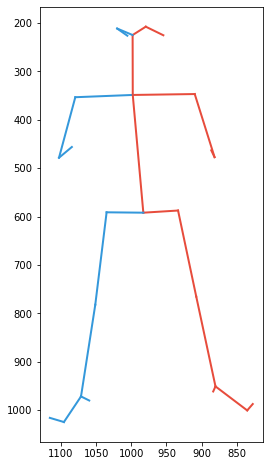

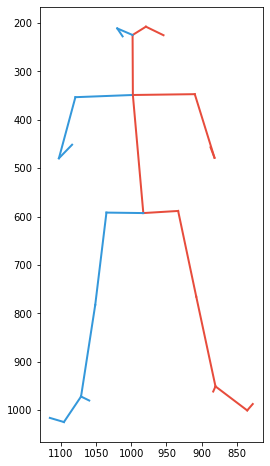

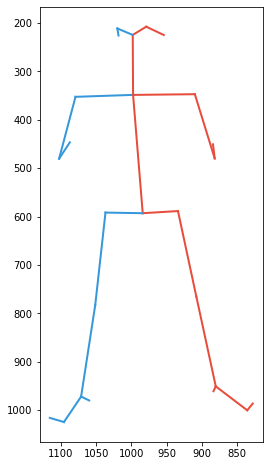

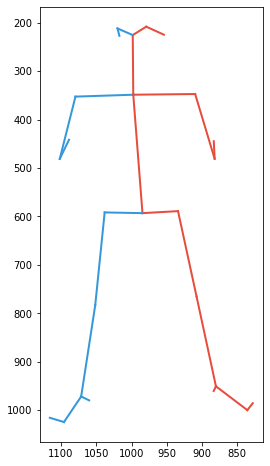

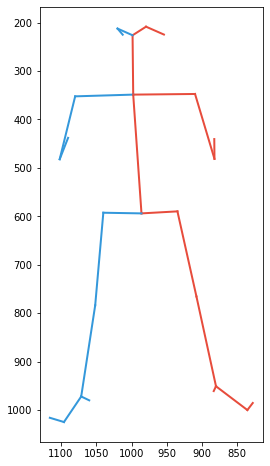

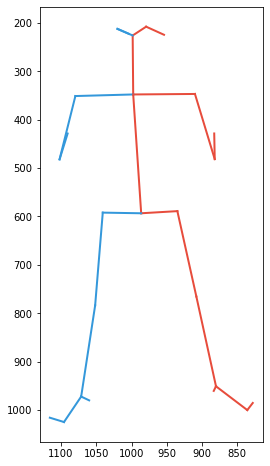

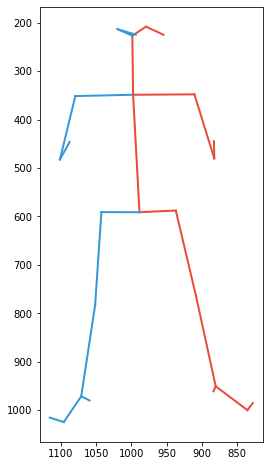

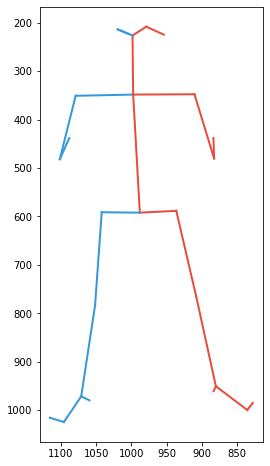

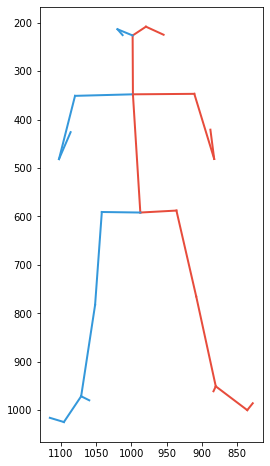

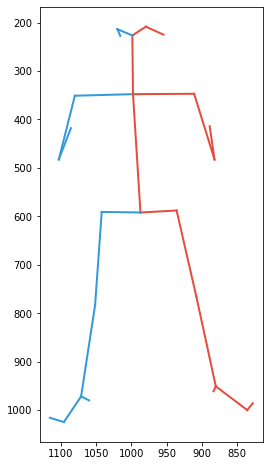

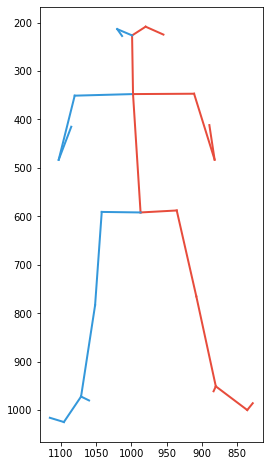

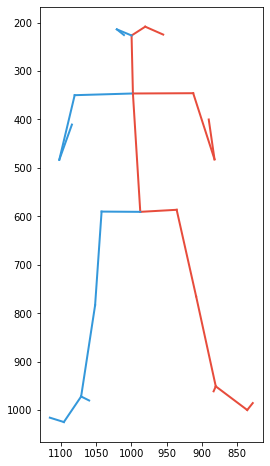

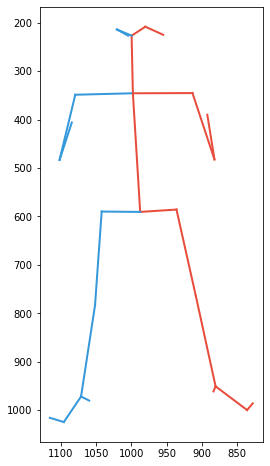

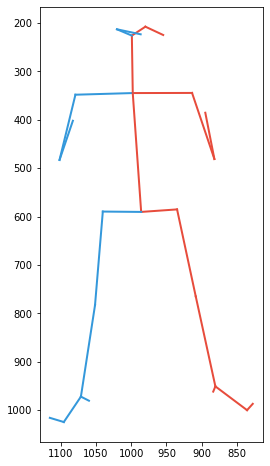

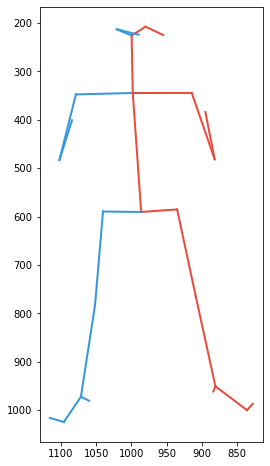

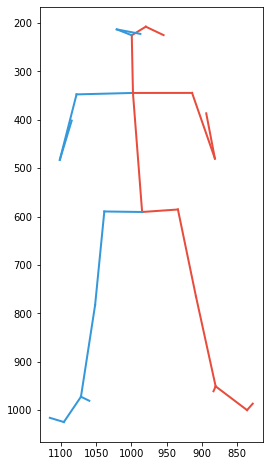

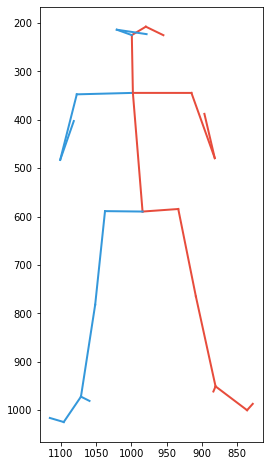

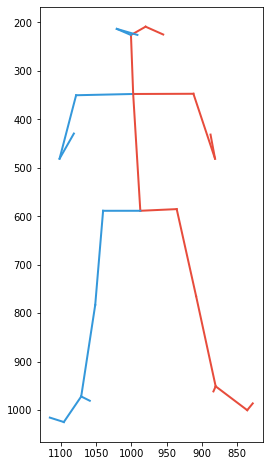

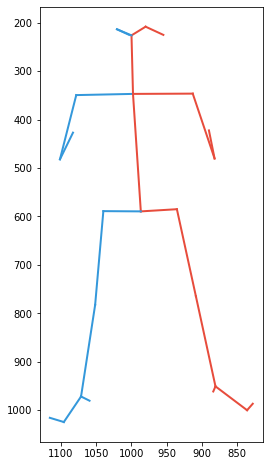

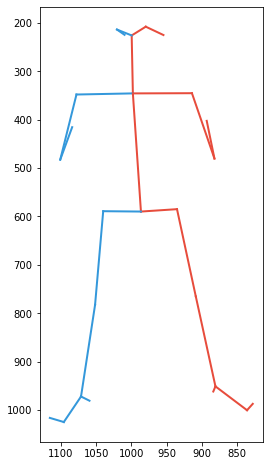

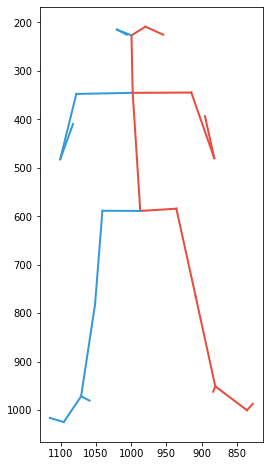

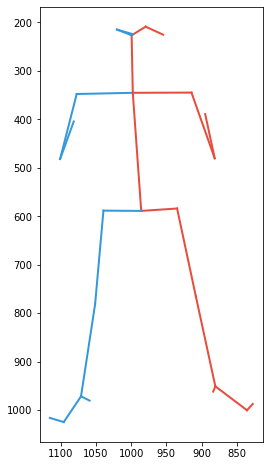

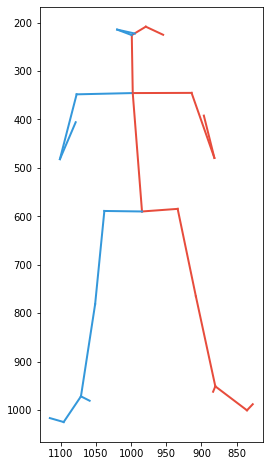

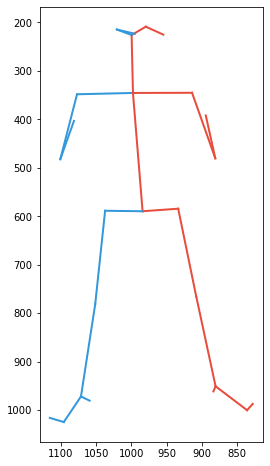

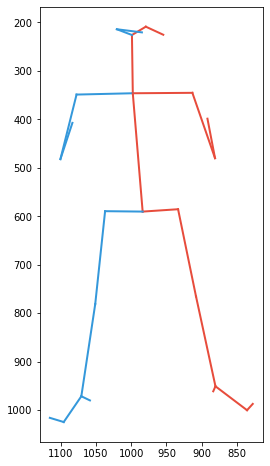

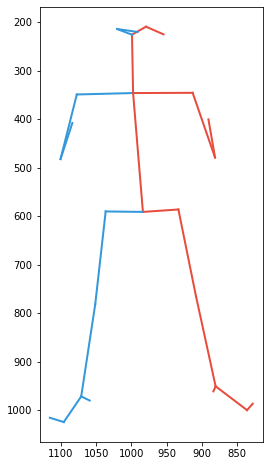

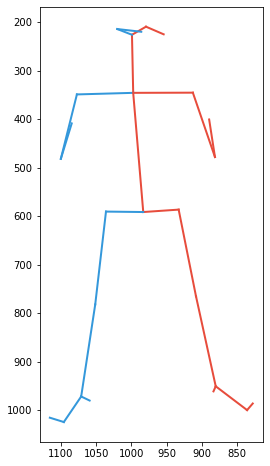

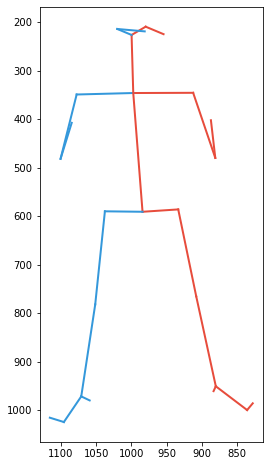

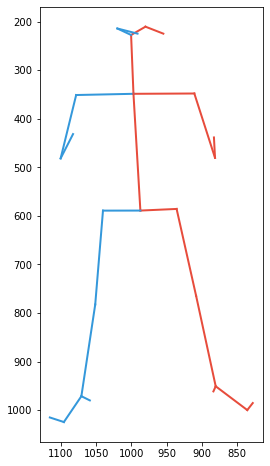

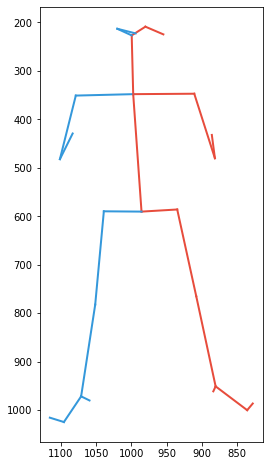

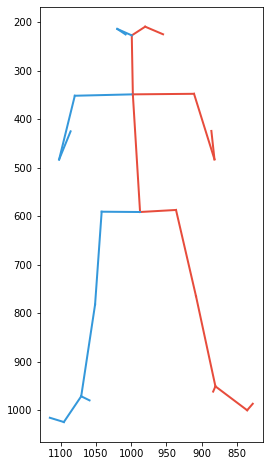

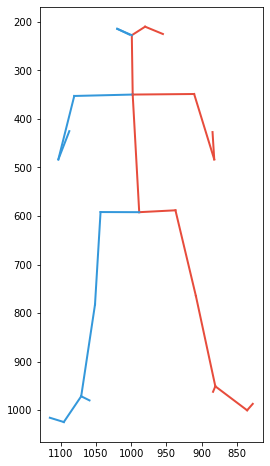

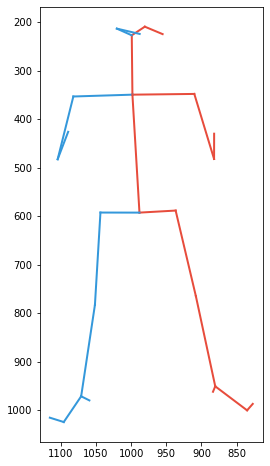

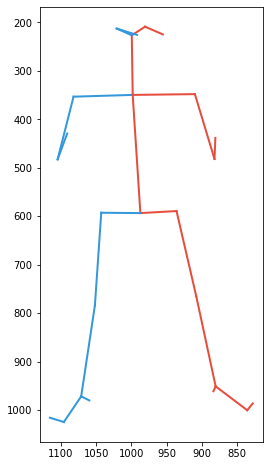

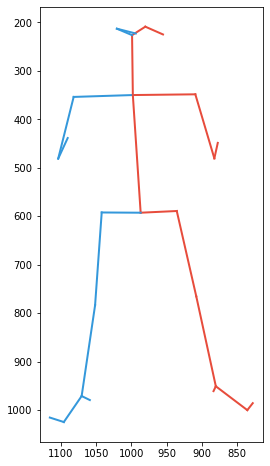

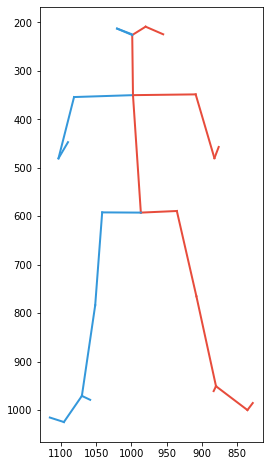

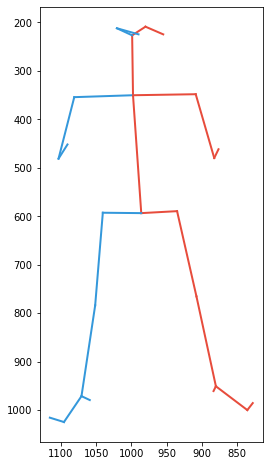

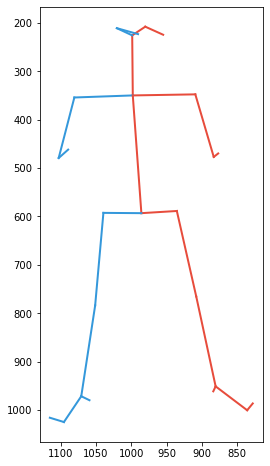

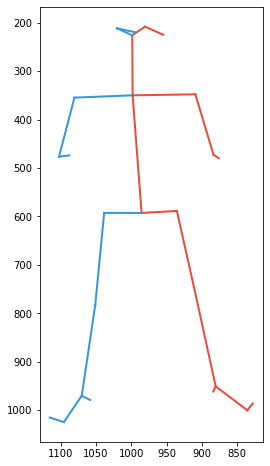

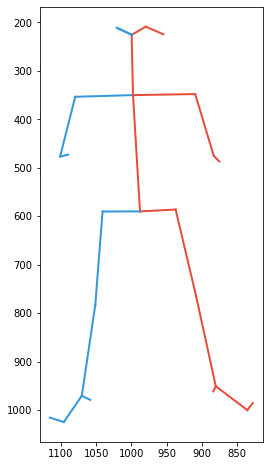

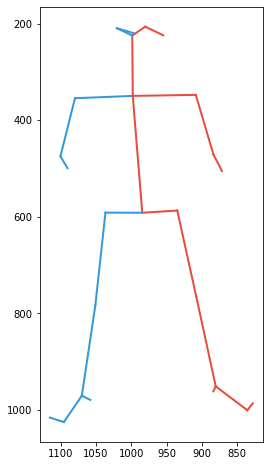

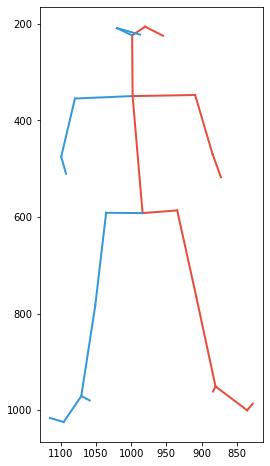

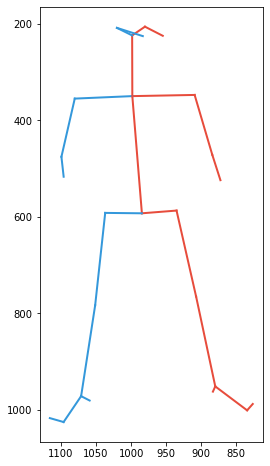

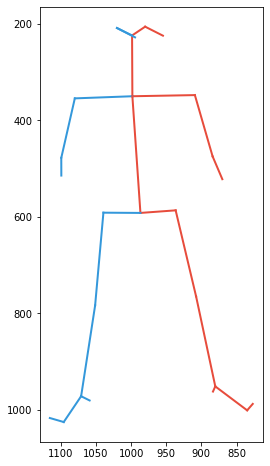

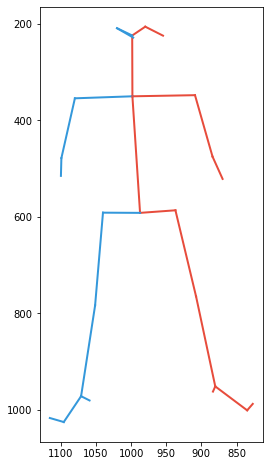

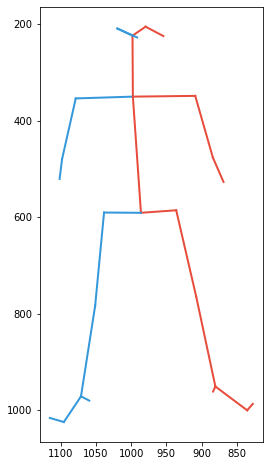

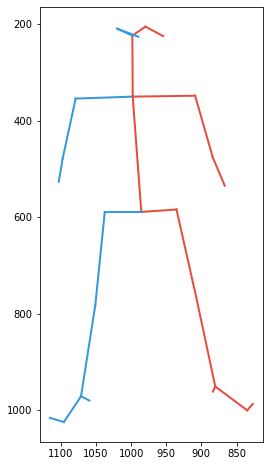

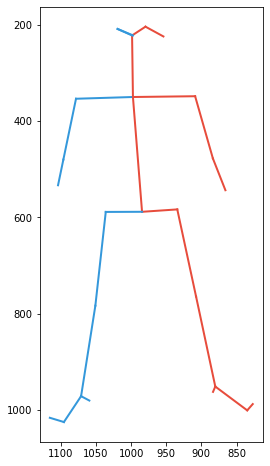

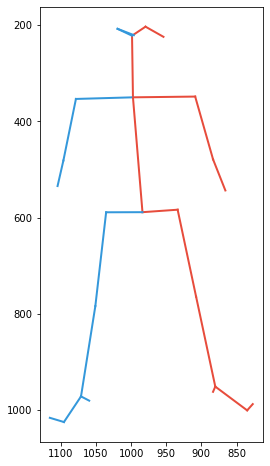

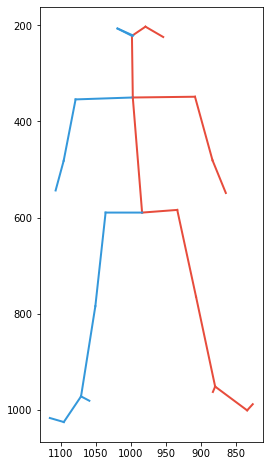

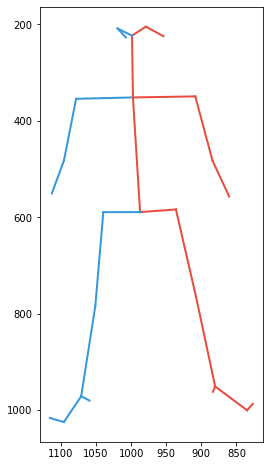

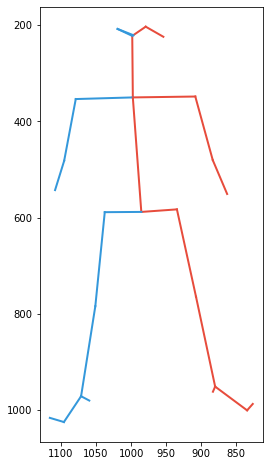

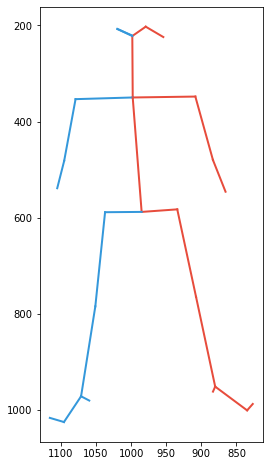

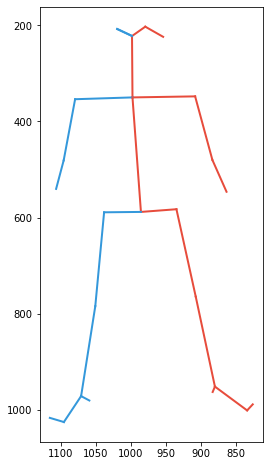

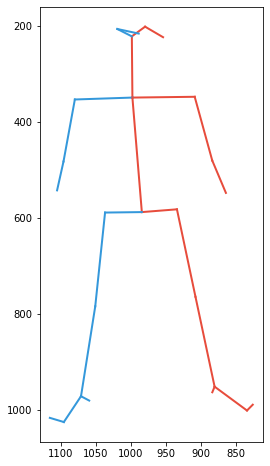

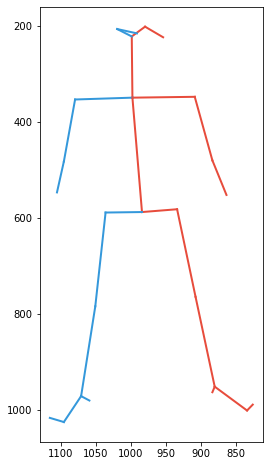

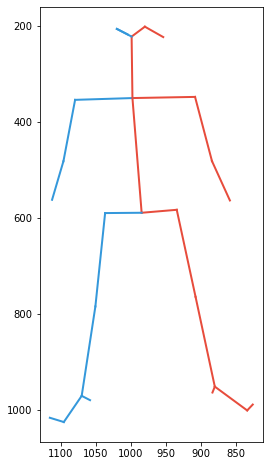

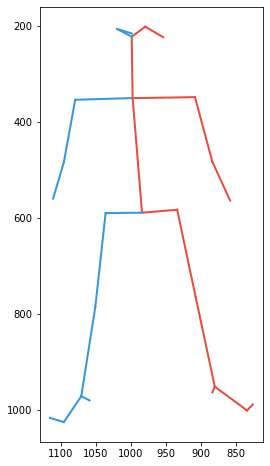

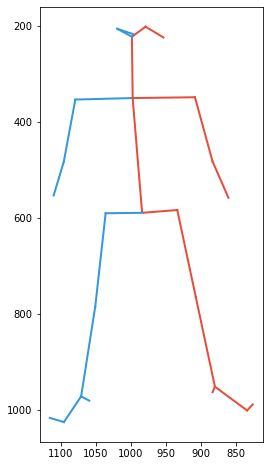

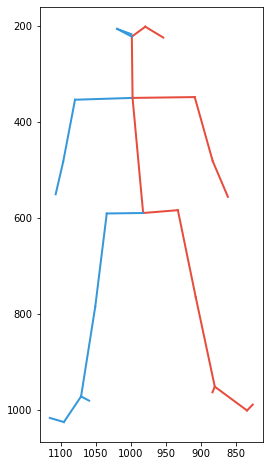

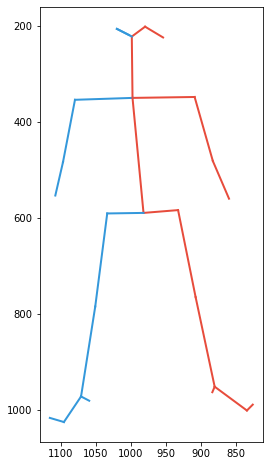

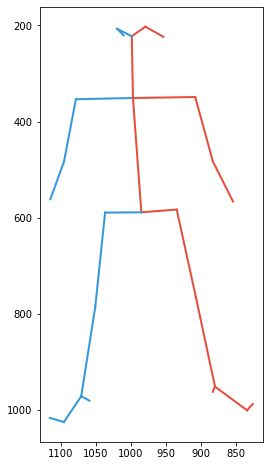

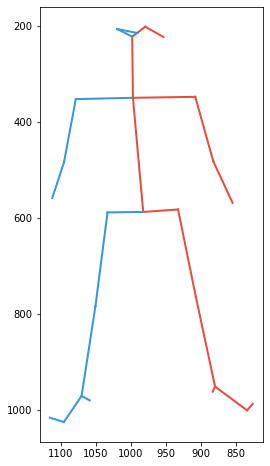

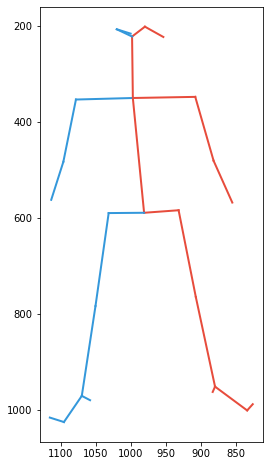

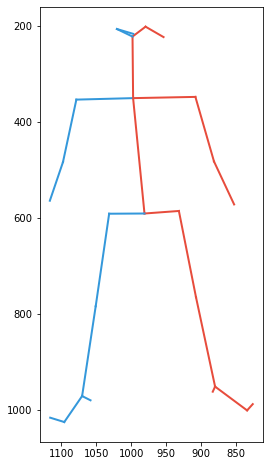

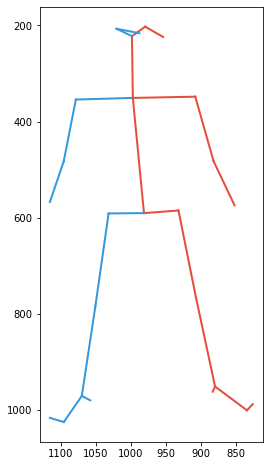

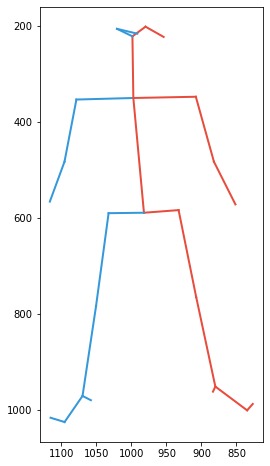

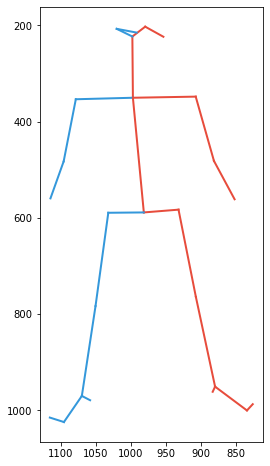

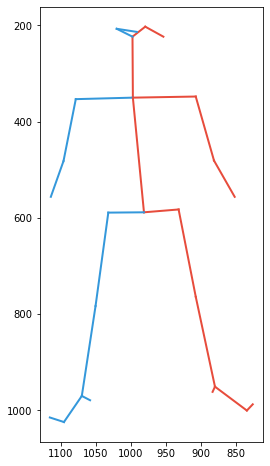

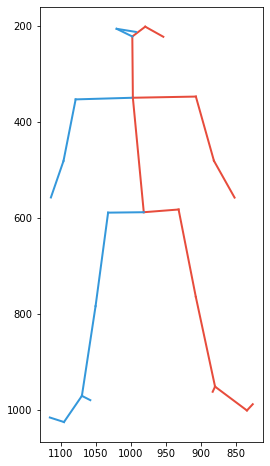

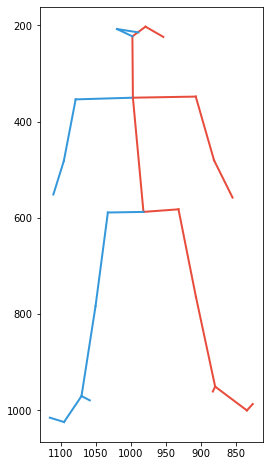

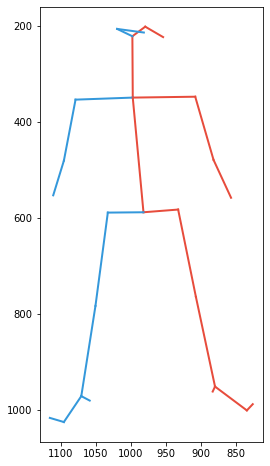

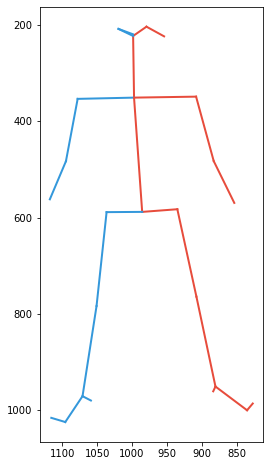

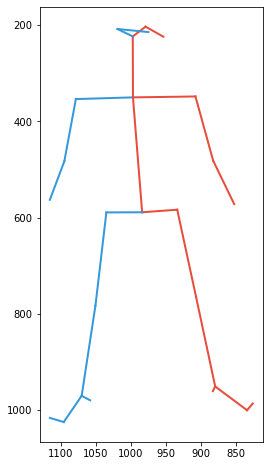

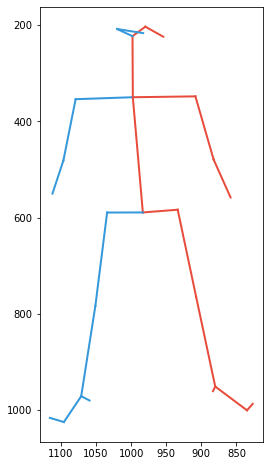

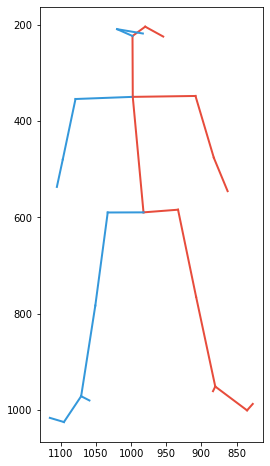

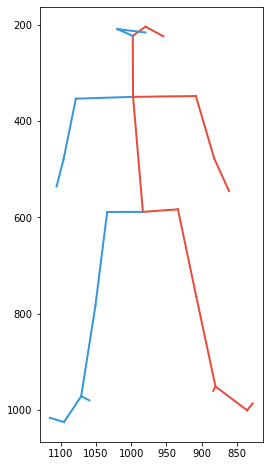

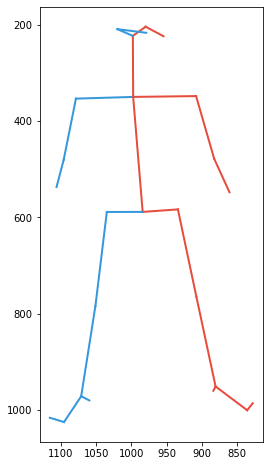

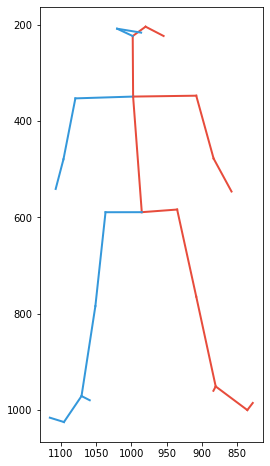

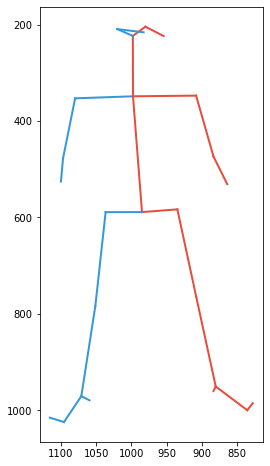

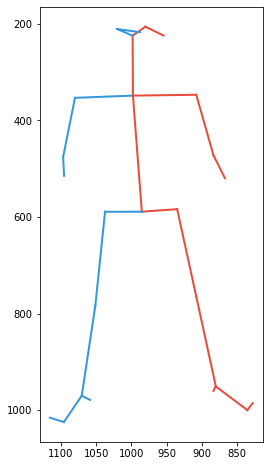

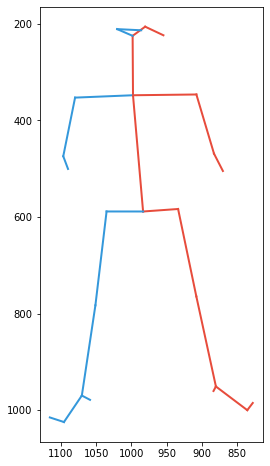

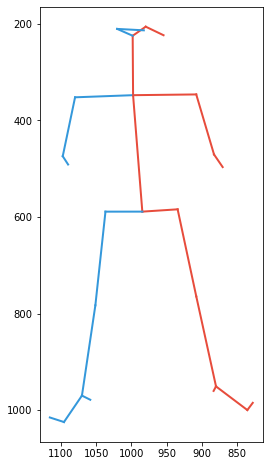

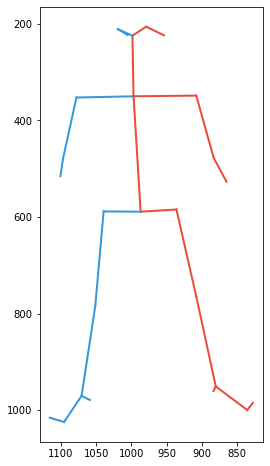

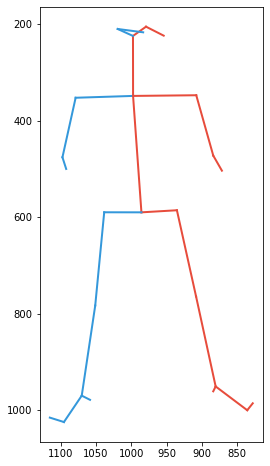

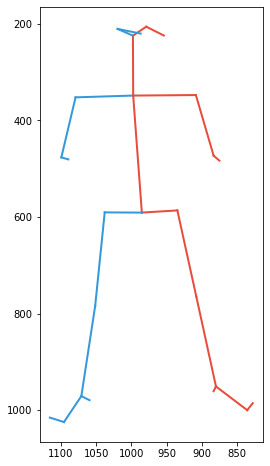

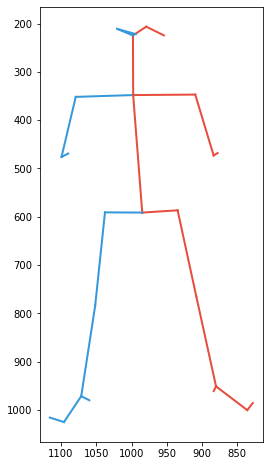

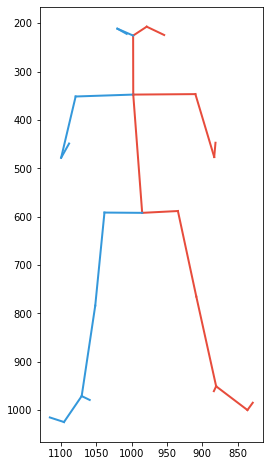

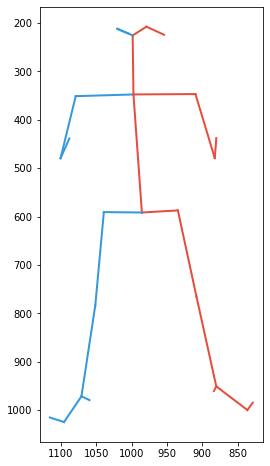

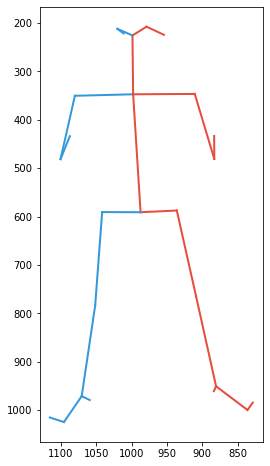

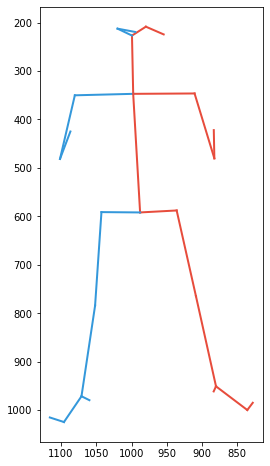

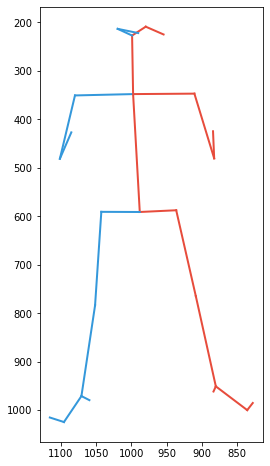

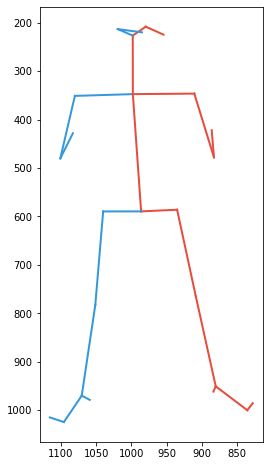

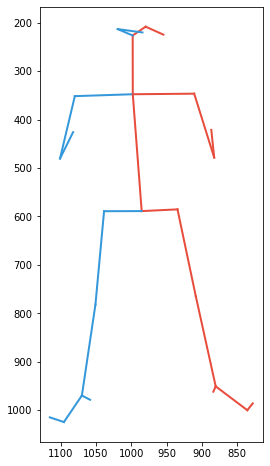

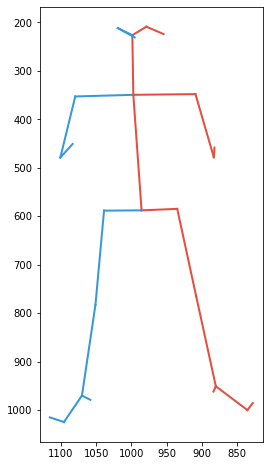

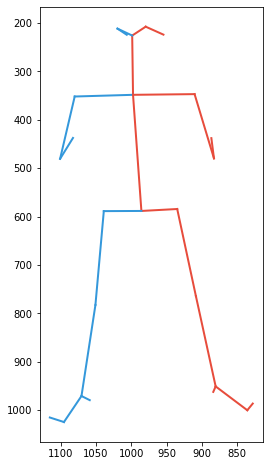

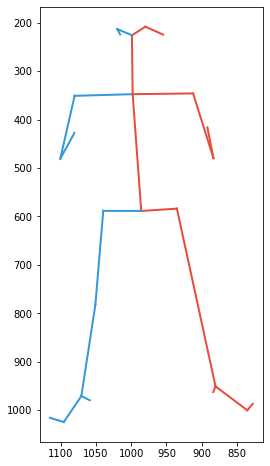

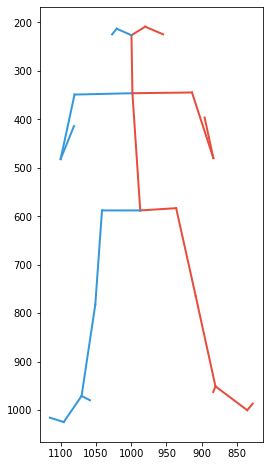

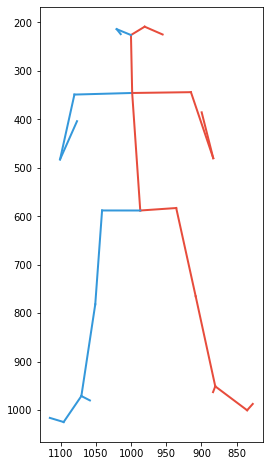

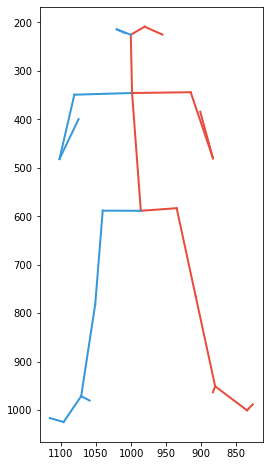

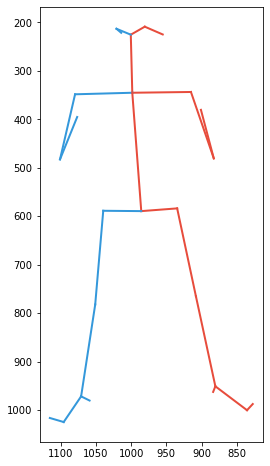

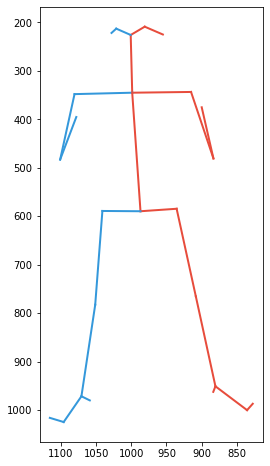

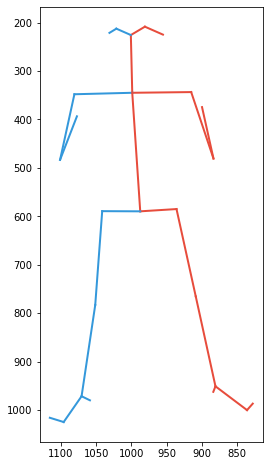

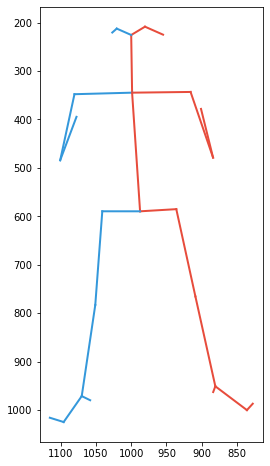

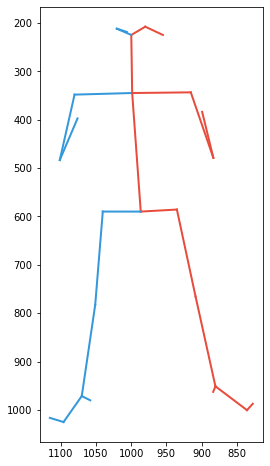

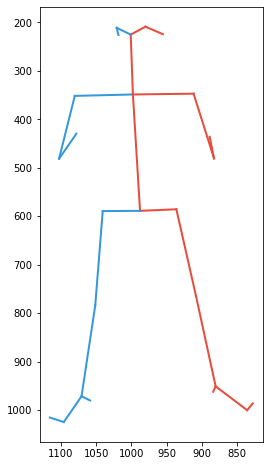

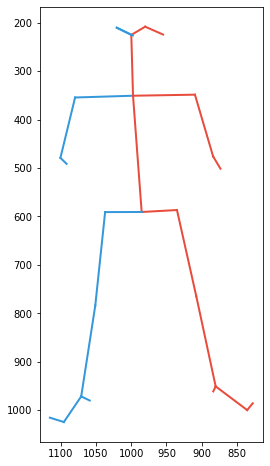

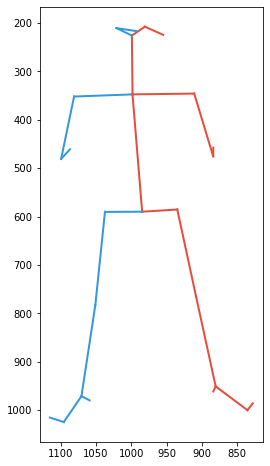

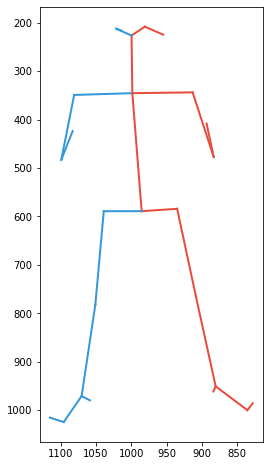

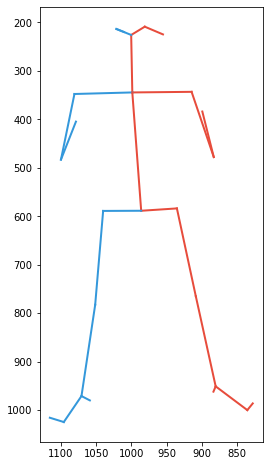

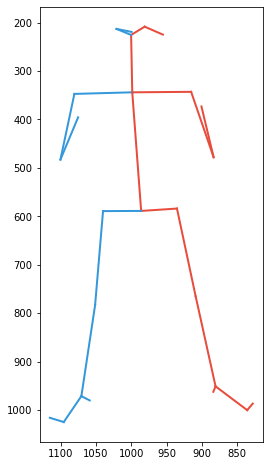

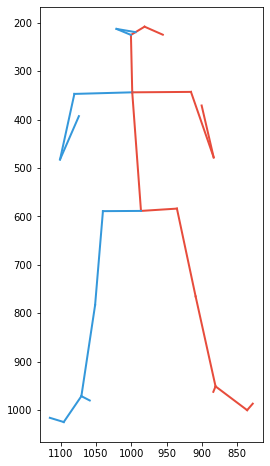

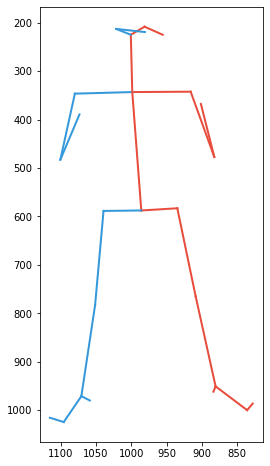

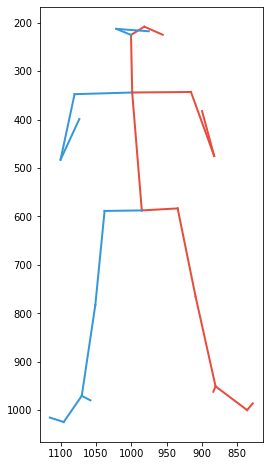

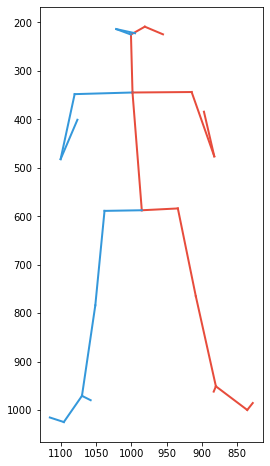

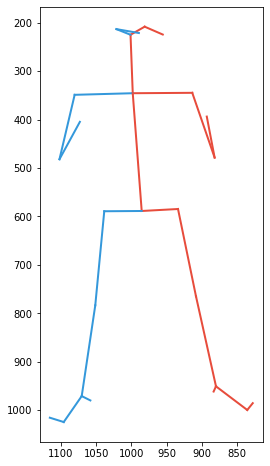

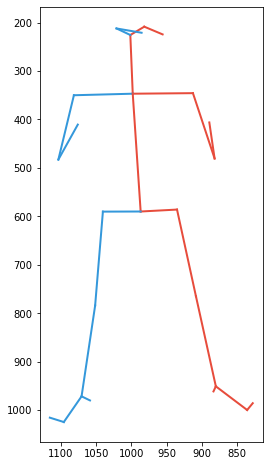

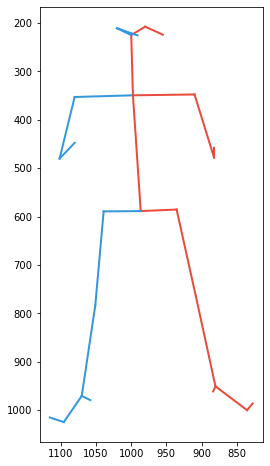

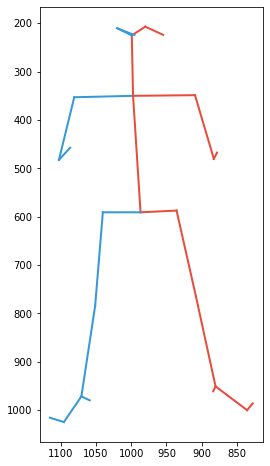

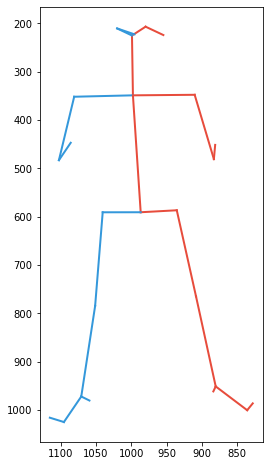

In [27]:
i = 0
for td in ps:
    fig = plt.figure(figsize=(4,8))
    ax = fig.add_subplot()
    ax.invert_xaxis()
    ax.invert_yaxis()
    draw2Dpose(td, ax)
    plt.show()
    fig.savefig('out_imgs/no_{}.png'.format(i))
    i += 1